In [192]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


os.getcwd()
ames_dimreduced = pd.read_csv(r"C:\Users\willf\OneDrive\Documents\NYDSA\Machine Learning Project\AMES_GIT\ames_dimreduced.csv", keep_default_na=False)

In [193]:
# Drop target var and unnecessary columns
ames_dimreduced = ames_dimreduced.drop(columns=['Unnamed: 0', 'PID', 'LogSalePrice'])
ames_dimreduced['OverallQual']


0       6
1       5
2       5
3       4
4       8
       ..
2551    6
2552    3
2553    5
2554    7
2555    8
Name: OverallQual, Length: 2556, dtype: int64

In [257]:
# Run XGboost with target encoding and pipeline creation

import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce


# Define dataset
X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

# Create target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Create transformer for target encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

# Create a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', xgb_preprocessor),
                           ('regressor', xgb.XGBRFRegressor(objective='reg:squarederror', random_state=42))])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Fit the pipeline
xgb_pipeline.fit(X_train, y_train)

# Evaluate
xgb_predictions = xgb_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

# Perform CV
scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", scores)


RMSE: 25453.55790472651
R-squared: 0.8943799170859765
Cross-validated R-squared scores: [0.86917508 0.88237441 0.90327528 0.88776952 0.88555892]


In [195]:
len(X_train.columns)

44

In [258]:
# Tune xgboost hyperparams

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Create XGboost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparams grid
param_dist = {
    'regressor__n_estimators': randint(100,1000),
    'regressor__learning_rate': uniform(0.01, 0.6),
    'regressor__max_depth': randint(3, 10),
    'regressor__min_child_weight': randint(1, 6),
    'regressor__gamma': uniform(0, 0.5),
    'regressor__subsample': uniform(0.5, 0.5),
    'regressor__colsample_bytree': uniform(0.5, 0.5)
}

# Randomized search
random_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='r2', random_state=42, n_jobs=-1)

# Fit random search model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'regressor__colsample_bytree': 0.8049983288913105, 'regressor__gamma': 0.41659745586808217, 'regressor__learning_rate': 0.11401879210466324, 'regressor__max_depth': 3, 'regressor__min_child_weight': 4, 'regressor__n_estimators': 661, 'regressor__subsample': 0.831261142176991}


In [259]:
len(X_train.columns)

44

In [260]:
# Rerun XGboost models with optimized hyper-parameter values

X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

# Create target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Create transformer for target encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

best_params_xgb = random_search.best_params_

# Create pipeline with best parameters
best_xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=best_params_xgb['regressor__n_estimators'],
                                   learning_rate=best_params_xgb['regressor__learning_rate'],
                                   max_depth=best_params_xgb['regressor__max_depth'],
                                   min_child_weight=best_params_xgb['regressor__min_child_weight'],
                                   gamma=best_params_xgb['regressor__gamma'],
                                   subsample=best_params_xgb['regressor__subsample'],
                                   colsample_bytree=best_params_xgb['regressor__colsample_bytree'],
                                   random_state=42))
])

# Fit 
best_xgb_pipeline.fit(X_train, y_train)

# Predict 
xgb_predictions = best_xgb_pipeline.predict(X_test)

# Calc metrics
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")


RMSE: 19413.752684620038
R-squared: 0.9385575540373456


In [261]:
# Checking lengths again
X_train_preprocessed = best_xgb_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = best_xgb_pipeline.named_steps['preprocessor'].transform(X_test)

xgb_model = best_xgb_pipeline.named_steps['regressor']

X_train_preprocessed.shape

(1789, 44)

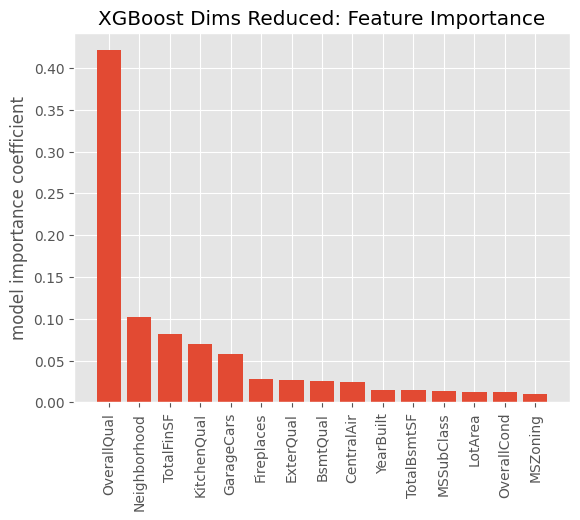

In [262]:
# Extract feature importance from best xgb model
xgb_feature_importances = best_xgb_pipeline.named_steps['regressor'].feature_importances_

target_encoded_feature = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
                          'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S']

# Get numeric feature names
numeric_features = X.select_dtypes(exclude=['object']).columns

# Combine all feature names
all_features = np.concatenate([target_encoded_feature, numeric_features])

# Map feature importance to feature names
feature_importance_dict = dict(zip(all_features, xgb_feature_importances))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

xgb_original_feature_importance = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'], index=None)

# Plot Feature Importance - top 15
import matplotlib.pyplot as plt

xgb_importance_15 = xgb_original_feature_importance.head(15)
plt.bar(xgb_importance_15['Feature'], xgb_importance_15['Importance'])
plt.xticks(rotation=90)
plt.ylabel('model importance coefficient')
plt.title("XGBoost Dims Reduced: Feature Importance")
plt.show()


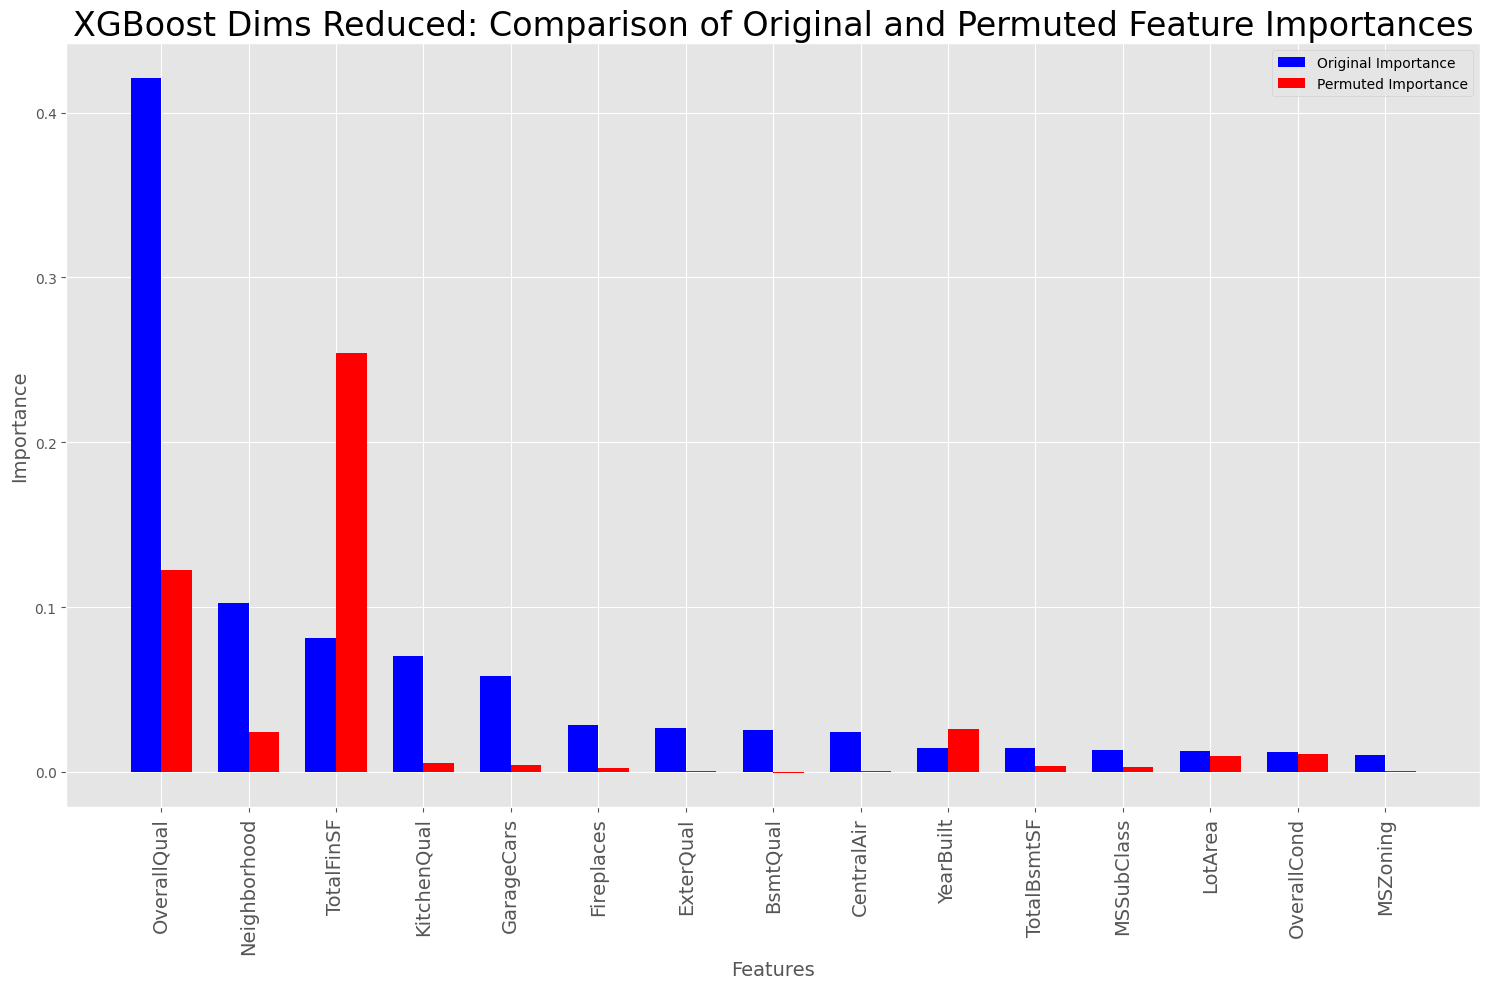

In [263]:
# Run permuted feature importance and plot vs model feature importance
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
import joblib

def permuted_feature_importance(pipeline, X_test, y_test):
    baseline_r2 = r2_score(y_test, pipeline.predict(X_test))
    importances = {}

    for feature in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

        permuted_r2 = r2_score(y_test, pipeline.predict(X_test_permuted))
        importances[feature] = baseline_r2 - permuted_r2

    return importances

# Calc permuted importance
xgb_permuted_importances = permuted_feature_importance(best_xgb_pipeline, X_test, y_test)

# Convert to DF and sort
xgb_permuted_importances_df = pd.DataFrame.from_dict(xgb_permuted_importances, orient='index', columns=['Importance'])
xgb_permuted_importances_df.sort_values(by='Importance', ascending=False, inplace=True)


# Select top 15 features from model importances for comparison
top_features = xgb_original_feature_importance.head(15)['Feature']

# Initialize DF to store comparison
comparison_importances = pd.DataFrame(index=top_features)

# Get model importance for top features
comparison_importances['Original Importance'] = xgb_original_feature_importance.set_index('Feature').reindex(top_features)['Importance']

# Get permuted importance for top features
comparison_importances['Permuted Importance'] = xgb_permuted_importances_df.reindex(top_features)['Importance']

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
bar_width = 0.35
index = np.arange(len(top_features))

# Side by side bars
ax.bar(index, comparison_importances['Original Importance'], bar_width, label='Original Importance', color='b')
ax.bar(index + bar_width, comparison_importances['Permuted Importance'], bar_width, label='Permuted Importance', color='r')

ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
ax.set_title('XGBoost Dims Reduced: Comparison of Original and Permuted Feature Importances', fontsize=24)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_importances.index, rotation=90, fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()


In [264]:
print(len(X_train.columns))
print(X_train_preprocessed.shape[1])

44
44


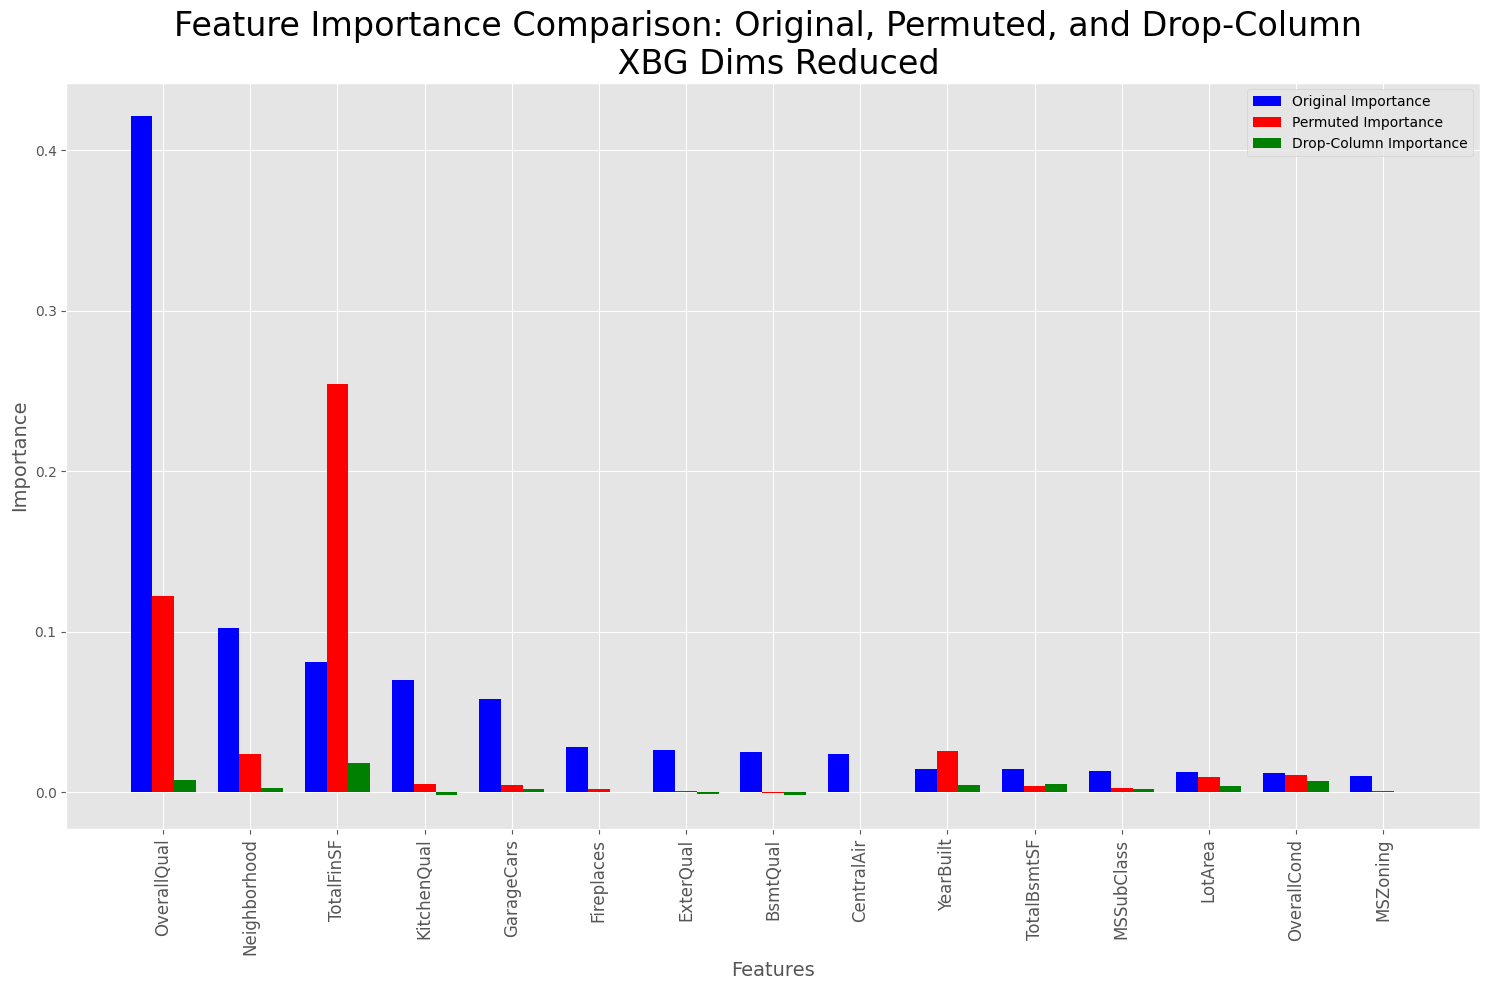

In [265]:
# Calc feature importance by dropping one column and seeing r2 vs baseline r2 with all features

from sklearn.metrics import r2_score
from sklearn.base import clone
import pandas as pd

# correct feature names
correct_feature_names = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
                         'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'] + list(numeric_features)

# Convert preprocessed data to DF to retain column names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=correct_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=correct_feature_names)

# Define drop-column importance function
def dropcol_importances(model, X_train, y_train, X_test, y_test, feature_names):
    baseline = r2_score(y_test, model.predict(X_test))
    importances = {}

    for col in feature_names:
        X_train_dropped = X_train.drop(columns=col)
        X_test_dropped = X_test.drop(columns=col)
        model_ = clone(model)
        model_.fit(X_train_dropped, y_train)
        score = r2_score(y_test, model_.predict(X_test_dropped))
        importances[col] = baseline - score
    
    return importances

# Clone model from pipeline
model_clone = clone(best_xgb_pipeline.named_steps['regressor'])

# Fit cloned model
model_clone.fit(X_train_preprocessed_df, y_train)

# Calc drop-column feature importance
xgb_dropcol_importances = dropcol_importances(model_clone, X_train_preprocessed_df, y_train, X_test_preprocessed_df, y_test, correct_feature_names)

# Convert to DF
xgb_dropcol_importances_df = pd.DataFrame.from_dict(xgb_dropcol_importances, orient='index', columns=['Importance'])
xgb_dropcol_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Add drop-column importances to the comparison DF
comparison_importances['Drop-Column Importance'] = xgb_dropcol_importances_df.reindex(top_features)['Importance']

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
bar_width = 0.25
index = np.arange(len(top_features))

ax.bar(index, comparison_importances['Original Importance'], bar_width, label='Original Importance', color='b')
ax.bar(index + bar_width, comparison_importances['Permuted Importance'], bar_width, label='Permuted Importance', color='r')
ax.bar(index + 2 * bar_width, comparison_importances['Drop-Column Importance'], bar_width, label='Drop-Column Importance', color='g')

ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
ax.set_title('Feature Importance Comparison: Original, Permuted, and Drop-Column \n XBG Dims Reduced', fontsize=24)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(comparison_importances.index, rotation=90, fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()


In [266]:
print(len(correct_feature_names))
print(X_train_preprocessed.shape[1])


44
44


In [267]:
# Check accuracy drop-column feature importance by removing important features before processing - this checked out with TotalFinSF & OverallQual

ames_dimreduced_exTSF = ames_dimreduced.drop('OverallQual', axis=1)

X = ames_dimreduced_exTSF.drop('SalePrice', axis=1)
y = ames_dimreduced_exTSF['SalePrice']


# Define target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Define transformer for target encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

best_params_xgb = random_search.best_params_

# Create a pipeline 
best_xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=best_params_xgb['regressor__n_estimators'],
                                   learning_rate=best_params_xgb['regressor__learning_rate'],
                                   max_depth=best_params_xgb['regressor__max_depth'],
                                   min_child_weight=best_params_xgb['regressor__min_child_weight'],
                                   gamma=best_params_xgb['regressor__gamma'],
                                   subsample=best_params_xgb['regressor__subsample'],
                                   colsample_bytree=best_params_xgb['regressor__colsample_bytree'],
                                   random_state=42))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)


# Fit 
best_xgb_pipeline.fit(X_train, y_train)

# Predict 
xgb_predictions = best_xgb_pipeline.predict(X_test)

# Calc metrics
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")



RMSE: 20633.480253432994
R-squared: 0.9305944046222917


In [268]:
print(X_train_preprocessed.shape)
print(len(correct_feature_names))
print(X_train_preprocessed.shape[1])


(1789, 44)
44
44


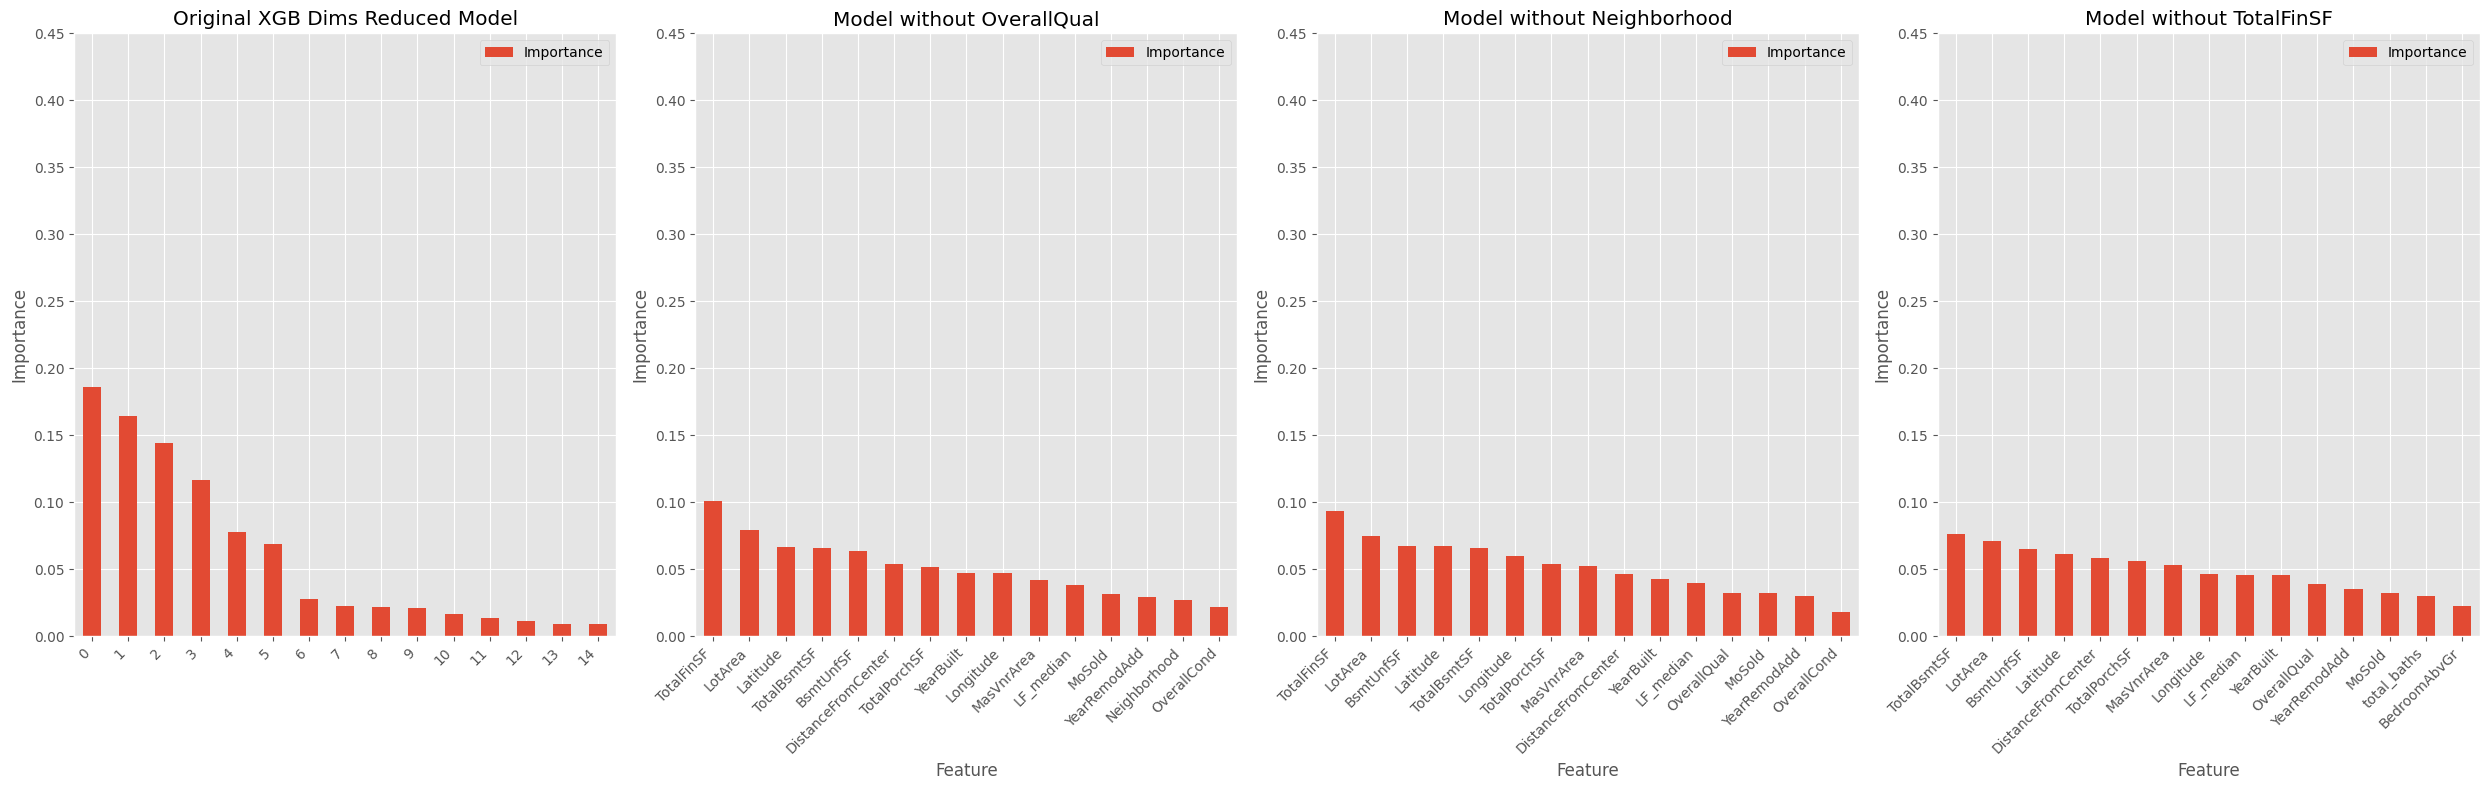

In [269]:
# Plot model feature importance with major features dropped (one at a time)

specific_columns = ['OverallQual', 'Neighborhood', 'TotalFinSF']
dropcol_importances_specific = {}

def model_importances_without_feature(model, X_train, y_train, feature):
    # Drop the specified feature
    X_train_dropped = X_train.drop(columns=feature)

    # Clone and fit the model with modified dataset
    model_ = clone(model)
    model_.fit(X_train_dropped, y_train)

    # Get the feature importances
    importances = model_.get_booster().get_score(importance_type='weight')

    # Normalize importances
    total_importance = sum(importances.values())
    normalized_importances = {k: v / total_importance for k, v in importances.items()}

    # Transform importances to sorted list
    sorted_importances = sorted(normalized_importances.items(), key=lambda x: x[1], reverse=True)

    return sorted_importances

# Initialize importances dict
importances_without_specific_feature = {}

# Calc importances for each of the dropped col datasets
for col in specific_columns:
    importances_without_specific_feature[col] = model_importances_without_feature(model_clone, X_train_preprocessed_df, y_train, col)


# Func to get top 15 features from sorted importances
def get_top_15_features(sorted_importances):
    return [feature for feature, _ in sorted_importances[:15]]

# Original top 15 features
original_top_15_features = get_top_15_features(sorted_feature_importance)

# Compare with top 15 features when each specific column is removed
top_15_comparison = {col: get_top_15_features(importances_without_specific_feature[col]) for col in specific_columns}

# Plot
fig, axes = plt.subplots(1, 4, figsize=(25, 8))  # 4 plots: original and 3 for each feature removed

# Plot original model importances
xgb_feature_importance[:15].plot(kind='bar', ax=axes[0], title='Original XGB Dims Reduced Model')
axes[0].set_ylim(0, 0.45)  

# Plot models with specific columns removed
for i, col in enumerate(specific_columns):
    # Convert the list of tuples to DF and set 'Feature' as the index
    specific_importances_df = pd.DataFrame(importances_without_specific_feature[col], columns=['Feature', 'Importance']).set_index('Feature')
    # Plot  feature importances for top 15 features
    specific_importances_df[:15].plot(kind='bar', ax=axes[i+1], title=f'Model without {col}')
    # Set the y-axis limits to be consistent with the original model importances
    axes[i+1].set_ylim(0, 0.45)

for ax in axes:
    ax.set_ylabel('Importance')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


[11:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


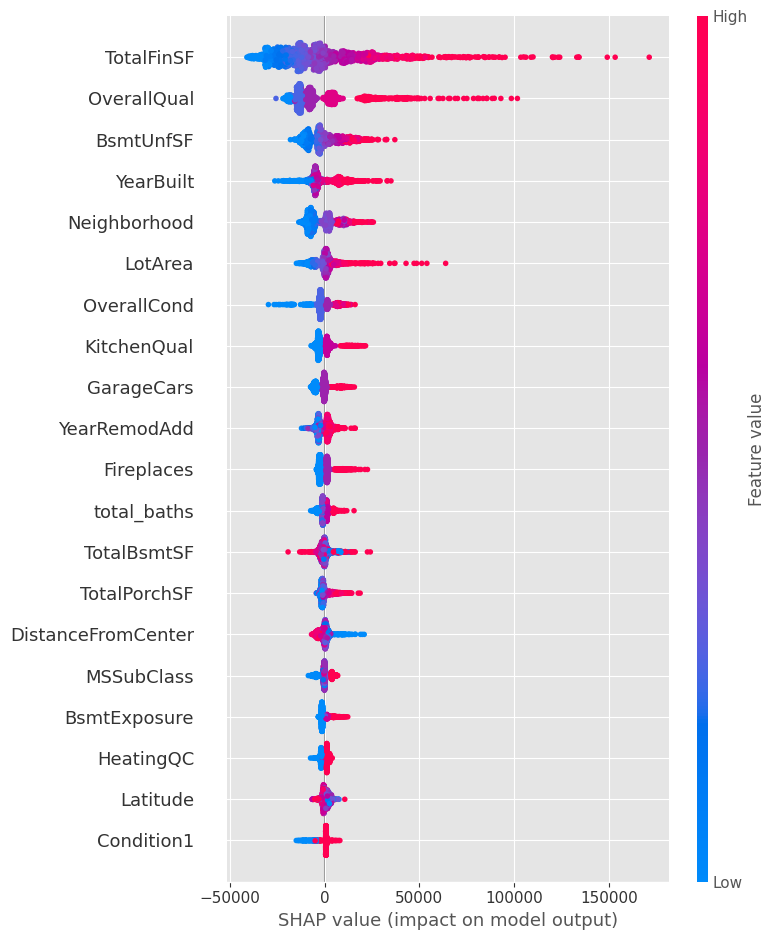

In [270]:
# Get XGBoost SHAP values

import shap
import scipy.sparse 

# Preprocess 
# 
# Convert one-hot encoded data to dense format
# if isinstance(X_train_preprocessed, scipy.sparse.csr.csr_matrix):
    # X_train_preprocessed = X_train_preprocessed.toarray()
# 

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_preprocessed)

shap_values = explainer(X_train_preprocessed)

shap.summary_plot(shap_values, X_train_preprocessed, feature_names=correct_feature_names)


In [271]:
X_train_preprocessed

array([[2.30520969e+05, 1.87000143e+05, 1.89269252e+05, ...,
        2.00000000e+00, 7.80000000e+01, 1.97400000e+03],
       [1.54324563e+05, 1.25886593e+05, 1.13332318e+05, ...,
        1.00000000e+00, 1.17000000e+02, 1.33000000e+03],
       [2.30520969e+05, 2.18664828e+05, 2.29246200e+05, ...,
        3.50000000e+00, 3.27000000e+02, 3.26300000e+03],
       ...,
       [2.30520969e+05, 1.87000143e+05, 1.96856975e+05, ...,
        2.50000000e+00, 3.41000000e+02, 2.15300000e+03],
       [1.67046152e+05, 1.87000143e+05, 1.45714715e+05, ...,
        1.50000000e+00, 3.50000000e+01, 1.45800000e+03],
       [2.30520969e+05, 1.87000143e+05, 1.96856975e+05, ...,
        3.50000000e+00, 4.20000000e+01, 2.27200000e+03]])

In [272]:

# Assuming X_train_preprocessed is already defined
# Note: Make sure this preprocessed data is in a format compatible with XGBoost and SHAP (e.g., NumPy array or pandas DataFrame)

# Initialize TreeExplainer
tree_explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP interaction values
# Note: Depending on the size of your dataset, you might want to limit the calculation to a subset of your data for faster execution
interaction_values = tree_explainer.shap_interaction_values(X_train_preprocessed[:2000])

# Optionally, you can also compute the regular SHAP values for comparison
shap_values = tree_explainer.shap_values(X_train_preprocessed[:2000])

# Inspect some of the interaction values to verify they're not all zeros
print(interaction_values[interaction_values != 0][:10])  # Print first 10 non-zero interaction values for inspection


[11:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[ 3.8717292e+03  9.2224518e+01 -2.2164368e+02  2.4979156e+01
 -5.1383972e-02 -1.6946411e+00  5.6574631e+00  7.9609772e+01
  5.3328552e+01 -4.2520142e+01]


In [273]:
X_train_preprocessed.shape

(1789, 44)

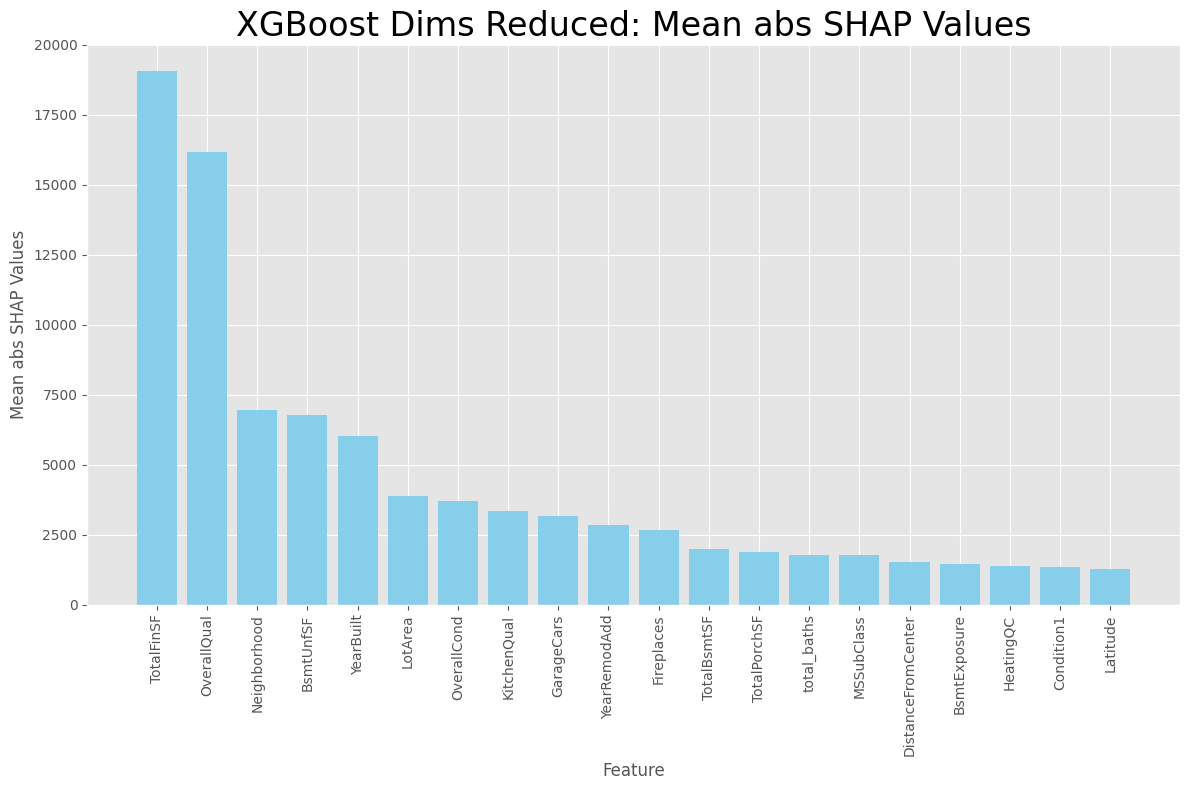

In [274]:
# Plot mean abs shap values 
xgb_mean_abs_shap = np.abs(shap_values).mean(axis=0)

feature_names = correct_feature_names

xgb_shap_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': xgb_mean_abs_shap
})

top_features = xgb_shap_feature_importance.sort_values(by='mean_abs_shap', ascending=False).head(20)

# Plot
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.bar(top_features['feature'], top_features['mean_abs_shap'], color='skyblue')
plt.ylabel('Mean abs SHAP Values')
plt.xlabel('Feature')
plt.title('XGBoost Dims Reduced: Mean abs SHAP Values', fontsize=24)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


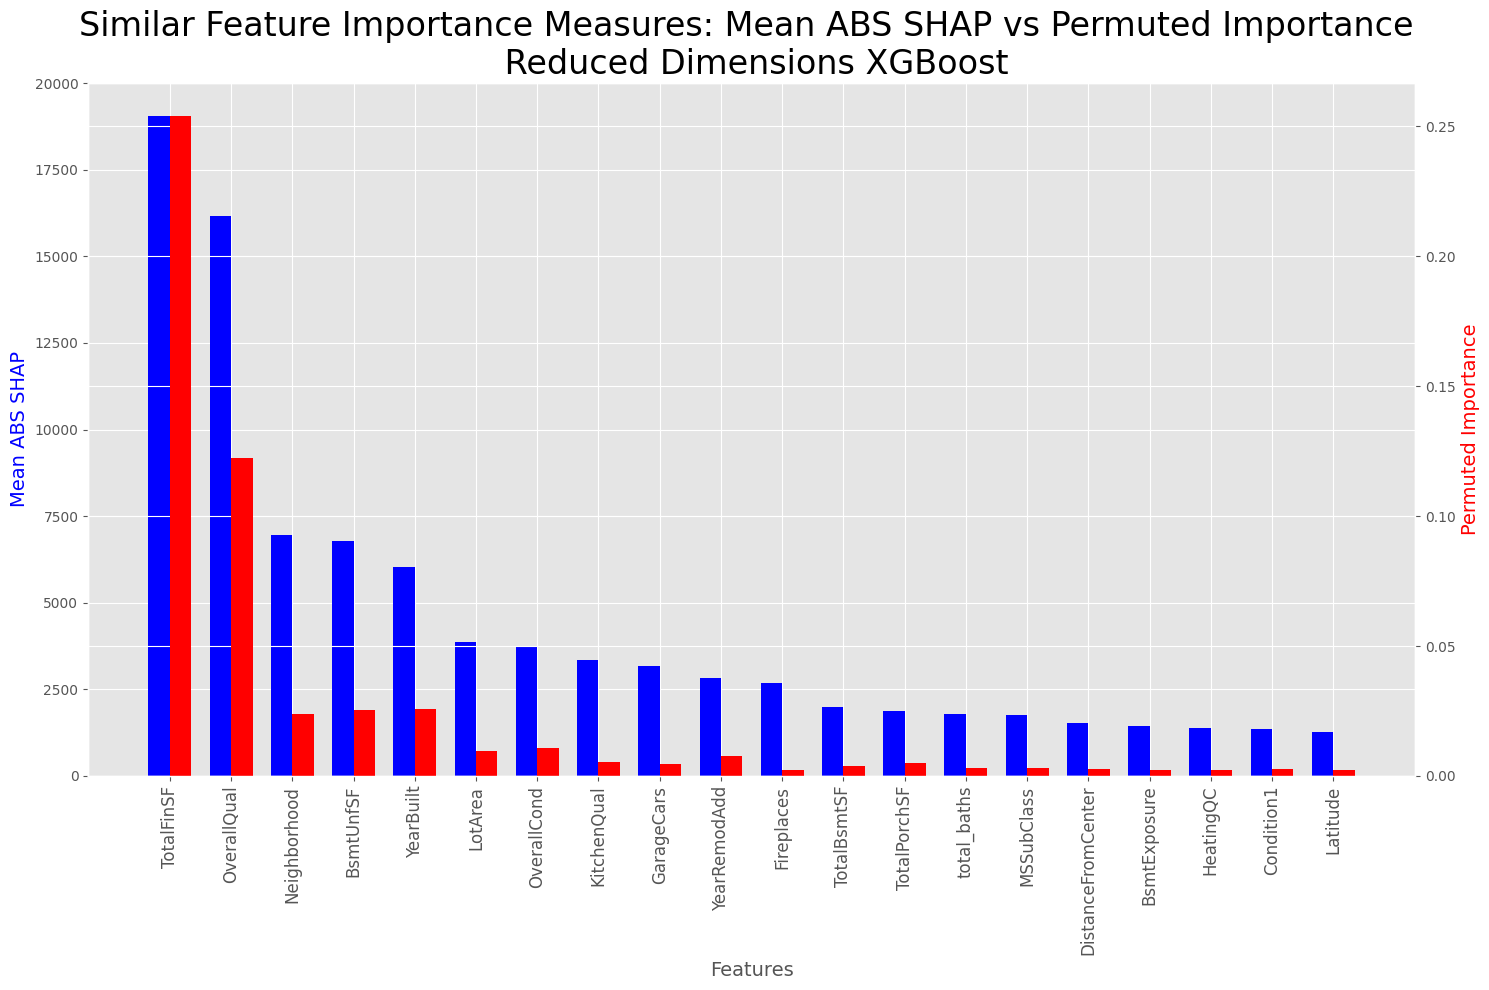

In [279]:
# Plot Mean ABS SHAP against Permuted Importance
full_importances = xgb_shap_feature_importance.merge(
    xgb_permuted_importances_df['Importance'],
    left_on='feature',
    right_index=True,
    how = 'left'
)

full_importances.sort_values(by='mean_abs_shap', ascending=False, inplace=True)
full_importances_20 = full_importances.head(20)

#Plot
fig, ax1 = plt.subplots(figsize=(15,10))

width = 0.35 

ind = np.arange(len(full_importances_20)) 

# Calculate the min values for both sets of data to align the zero on y-axis
min_shap = min(full_importances_20['mean_abs_shap'])
min_perm = min(full_importances_20['Importance'])
min_val = min(0, min_shap, min_perm) # Ensure that 0 is the upper limit if both min are positive
ax1.bar(ind - width/2, full_importances_20['mean_abs_shap'], width, color='blue', label='Mean ABS SHAP')

ax2 = ax1.twinx()
ax2.bar(ind + width/2, full_importances_20['Importance'], width, color='red', label='Permuted Importance')

ax1.set_xlabel('Features', fontsize=14)
ax1.set_ylabel('Mean ABS SHAP', fontsize=14, color='b')
ax2.set_ylabel('Permuted Importance', fontsize=14, color='r')

plt.title('Similar Feature Importance Measures: Mean ABS SHAP vs Permuted Importance \n Reduced Dimensions XGBoost', fontsize=24)

ax1.set_xticks(range(len(full_importances_20)))
ax1.set_xticklabels(full_importances_20['feature'], rotation=90, fontsize=12)

plt.tight_layout()
plt.show()

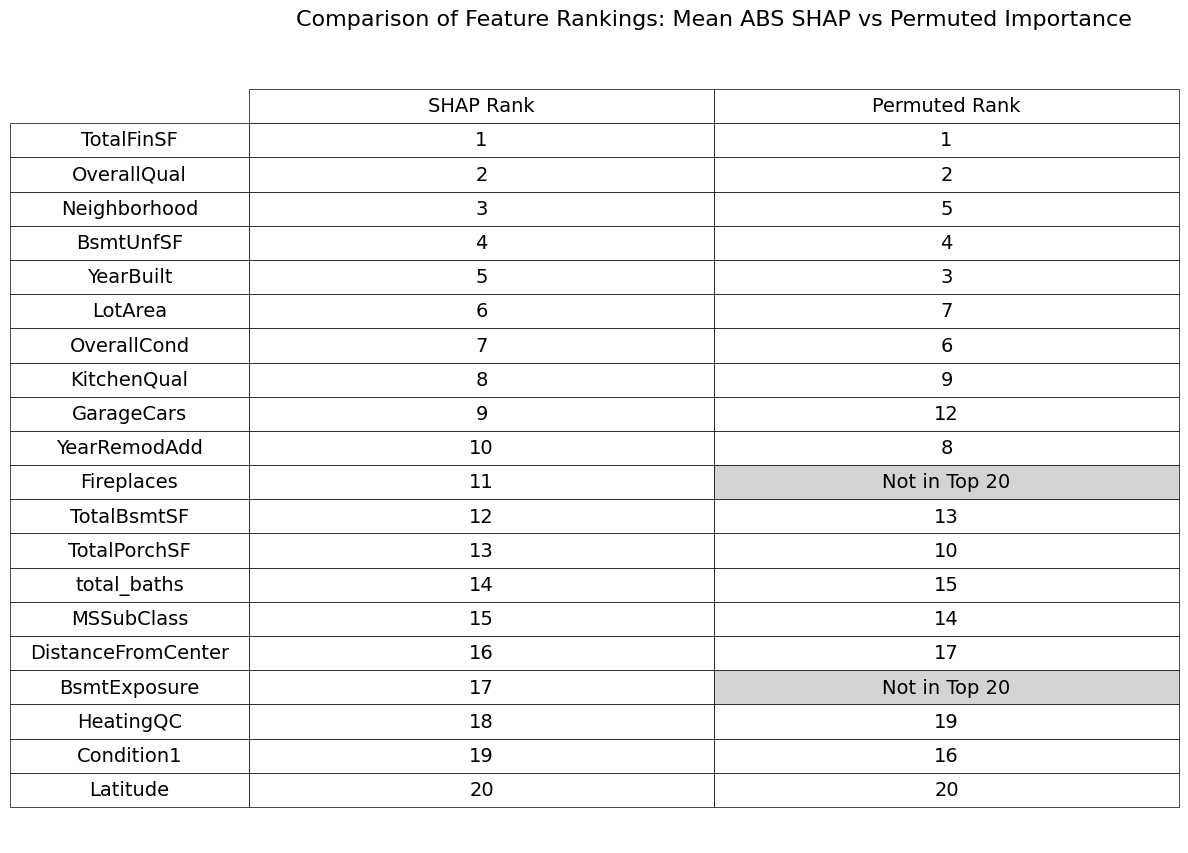

In [280]:
# Compare rank of feature importance using mean ABS SHAP vs permuted importance

# rank features based on 'mean_abs_shap' and 'Importance'
full_importances['shap_rank'] = full_importances['mean_abs_shap'].rank(ascending=False, method='min')
full_importances['permuted_rank'] = full_importances['Importance'].rank(ascending=False, method='min')

# Convert ranks to integers
full_importances['shap_rank'] = full_importances['shap_rank'].astype(int)
full_importances['permuted_rank'] = full_importances['permuted_rank'].astype(int)

# replace ranks outside top 20 with 'Not in Top 20'
full_importances['shap_rank_display'] = full_importances.apply(lambda x: x['shap_rank'] if x['shap_rank'] <= 20 else 'Not in Top 20', axis=1)
full_importances['permuted_rank_display'] = full_importances.apply(lambda x: x['permuted_rank'] if x['permuted_rank'] <= 20 else 'Not in Top 20', axis=1)

# Create DF 
ranks_for_display = full_importances[['feature', 'shap_rank_display', 'permuted_rank_display']].copy()
ranks_for_display.set_index('feature', inplace=True)

# Sort by 'shap_rank' 
ranks_for_display.sort_values(by='shap_rank_display', inplace=True, key=lambda col: col.replace('Not in Top 20', 21).astype(int))

# Create the table
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Comparison of Feature Rankings: Mean ABS SHAP vs Permuted Importance', fontsize=16, pad=20)

cell_text = ranks_for_display.head(20).values.tolist()
cell_colors = [['white' if isinstance(val, int) else 'lightgrey' for val in row] for row in cell_text]

table = plt.table(cellText=cell_text, cellColours=cell_colors,
                  rowLabels=ranks_for_display.head(20).index,
                  colLabels=['SHAP Rank', 'Permuted Rank'],
                  loc='center', cellLoc='center', rowLoc='center')

# Modify table properties
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

# Remove chart elements
ax.axis('off')

# Adjust layout to make room for the title
plt.subplots_adjust(top=0.9)

plt.show()


In [281]:
# # Get dropped-column mean abs SHAP values
# from sklearn.base import clone

# # Func to calc mean abs shap with single dropped feature
# def compute_mean_abs_shap_for_dropped_feature(model, X_train, y_train, dropped_feature, baseline_mean_abs_shap, all_features):
#     # Drop the feature 
#     X_train_dropped = X_train.drop(columns=dropped_feature)
#     model_clone = clone(model)
#     model_clone.fit(X_train_dropped, y_train)
#     explainer = shap.Explainer(model_clone, X_train_dropped)
#     shap_values_dropped = explainer(X_train_dropped)

#     # Calc mean abs SHAP vals
#     dropped_shap_mean = np.abs(shap_values_dropped.values).mean(axis=0)
    
#     # Align and calc abs change in mean SHAP vals
#     aligned_baseline_shap = np.array([baseline_mean_abs_shap[all_features.index(feature)] for feature in X_train_dropped.columns])
#     abs_change_in_shap = np.abs(aligned_baseline_shap - dropped_shap_mean)

#     # Map the abs change back to original features
#     abs_change_in_shap_dict = {feature: abs_change_in_shap[i] for i, feature in enumerate(X_train_dropped.columns)}
#     # zero change for  dropped feature
#     abs_change_in_shap_dict[dropped_feature] = 0

#     return abs_change_in_shap_dict

# # func to get 
# def shap_dropcol_importances(model, X_train_preprocessed, y_train, feature_names):
#     # Fit the model and create the SHAP explainer
#     model.fit(X_train_preprocessed, y_train)
#     explainer = shap.Explainer(model, X_train_preprocessed)
#     shap_values_baseline = explainer(X_train_preprocessed)
    
#     # Calc mean abs SHAP values for the baseline model
#     baseline_mean_abs_shap = np.abs(shap_values_baseline.values).mean(axis=0)
#     all_features = X_train_preprocessed.columns.tolist()

#     # Initialize a list to store results
#     results = []

#     # Compute the abs change in mean SHAP values for each feature when it is dropped
#     for col in feature_names:
#         if col in all_features:
#             abs_change_in_shap = compute_mean_abs_shap_for_dropped_feature(model, X_train_preprocessed, y_train, col, baseline_mean_abs_shap, all_features)
#             results.append(abs_change_in_shap)
    
#     print(results)

#     # Convert the list of dictionaries to a DataFrame
#     shap_importance_changes_df = pd.DataFrame(results, index=feature_names)

#     return shap_importance_changes_df

# # Calc SHAP values with each feature dropped
# shap_importance_changes_df = shap_dropcol_importances(model_clone, X_train_preprocessed_df, y_train, correct_feature_names)


In [282]:
# shap_importance_changes_df.to_csv("dropcol_SHAPs_1.csv")

In [283]:
print(X_train_preprocessed.shape)
xgb_model.get_booster().feature_names = correct_feature_names

print(len(xgb_model.get_booster().feature_names))


(1789, 44)
44


[11:12:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


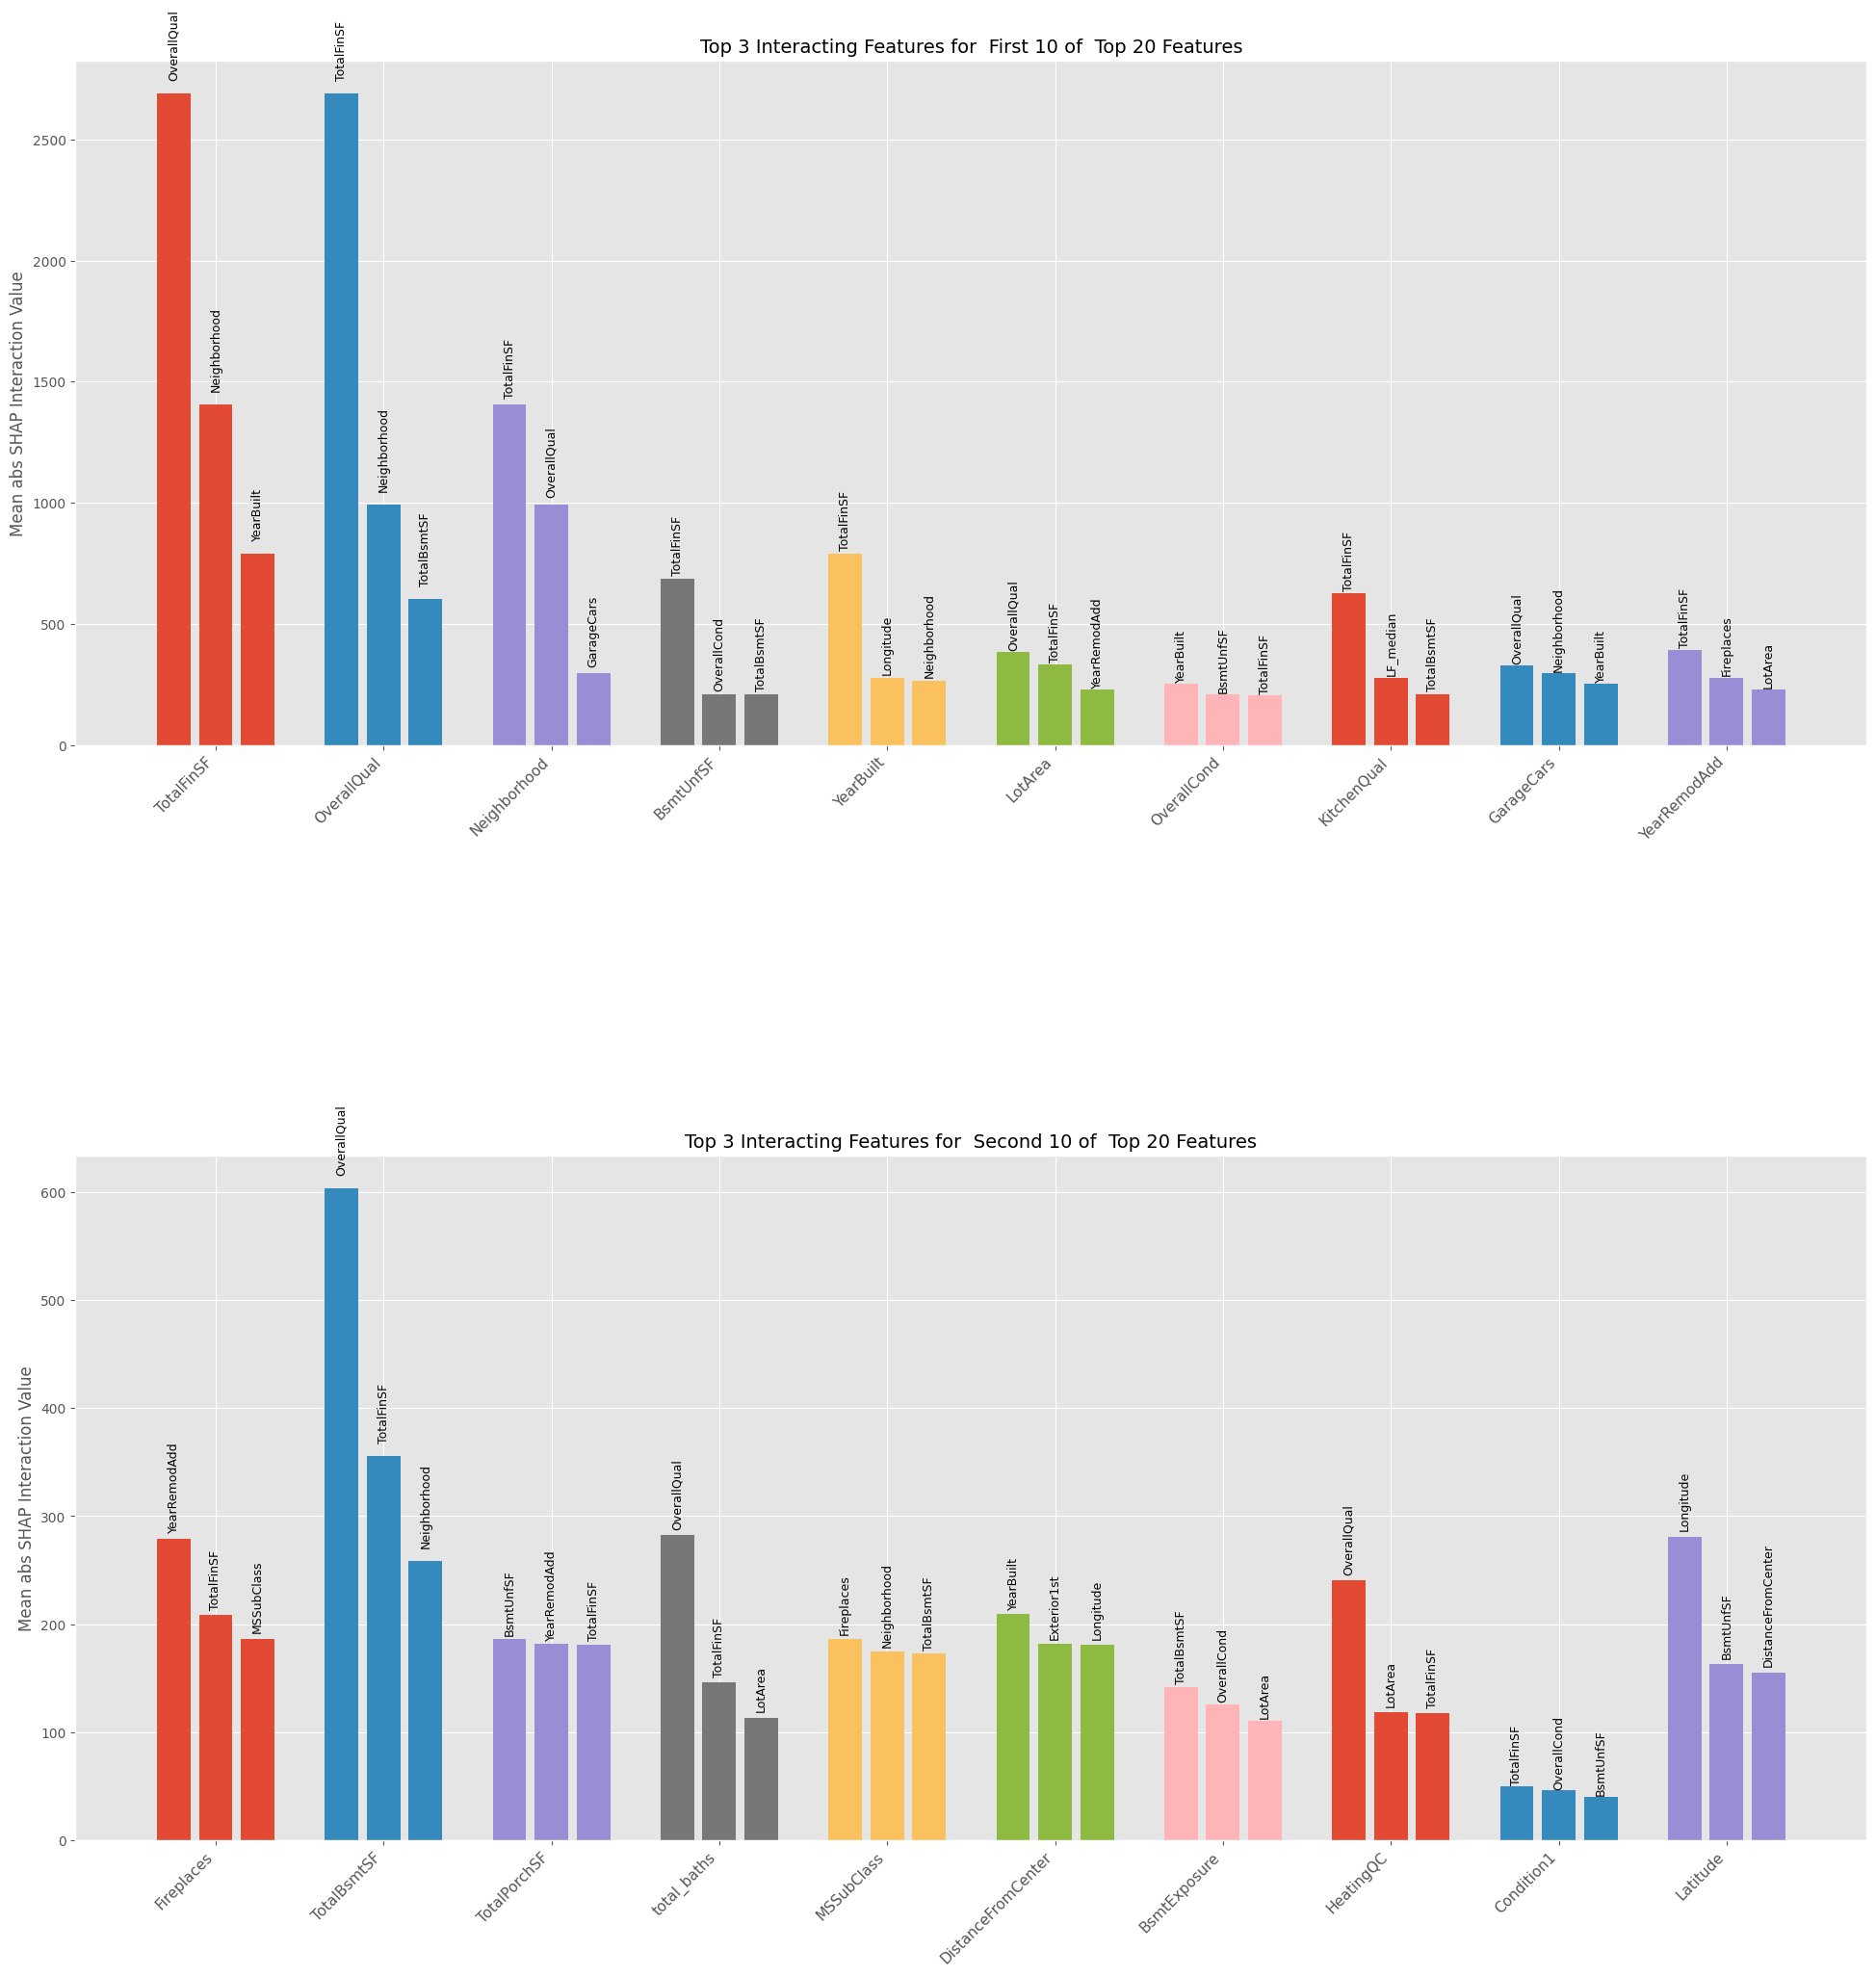

In [284]:
# Create and plot top 3 interaction features for each of  top 20 XGB model features (by mean abs SHAP val)

# Initialize TreeExplainer
tree_explainer = shap.TreeExplainer(xgb_model)

interaction_values = tree_explainer.shap_interaction_values(X_train_preprocessed)

# Calc mean interaction values across all samples
mean_interaction_values = np.abs(interaction_values).mean(axis=0)

top_20_feature_names = top_features['feature'].head(20)

top_20_feature_names_list = top_20_feature_names.tolist()


# Create a dictionary to hold  top 3 interactions for each feature
top_interactions = {}

# Iterate over each of the top 20 features
for feature in top_20_feature_names_list:
    # Check if the feature is in the correct_feature_names list
    if feature in correct_feature_names:
        # Get the index of the feature
        feature_idx = correct_feature_names.index(feature)

        # Get the interaction values of this feature with all other features
        feature_interactions = mean_interaction_values[feature_idx, :]
        
        # Get the top 3 interactions excluding the self-interaction
        top_3_idx = np.argsort(feature_interactions)[-4:-1]  # Exclude last one: the feature itself
        top_3_features = [correct_feature_names[i] for i in top_3_idx]
        top_3_values = feature_interactions[top_3_idx]

        # Store in dictionary
        top_interactions[feature] = (top_3_features, top_3_values)
    else:
        print(f"Feature '{feature}' not found in correct_feature_names")

# Create func for plotting
def plot_feature_interactions(interactions_dict, features, ax):
    for i, feature in enumerate(features):
        # Ensure feature is in the dictionary
        if feature not in interactions_dict:
            print(f"Feature '{feature}' not in interactions_dict")
            continue

        interacting_features, values = interactions_dict[feature]

        # Sort the values in descending order and get sorted indices
        sorted_idx = np.argsort(values)[::-1].astype(int)  # Convert to integer
        values = values[sorted_idx]

        # Use list comprehension for indexing
        interacting_features = [interacting_features[i] for i in sorted_idx]

        # ... rest of the code ...


        # Position of bars for this feature
        bar_positions = np.array(range(i*4, i*4 + 3))
        
        # Plot  bars
        ax.bar(bar_positions, values)

        # Annotate bars with feature names
        for pos, val, interact_feature in zip(bar_positions, values, interacting_features):
            ax.text(pos, val + 0.02 * max(values), interact_feature, ha='center', va='bottom', rotation=90, fontsize=9)

    # Set  x-ticks to be in  middle of each group of bars
    ax.set_xticks([i*4 + 1 for i in range(len(features))])
    ax.set_xticklabels(features, rotation=45, ha='right', fontsize=11)
    ax.set_ylabel('Mean abs SHAP Interaction Value', fontsize=12)

# Split  top 20 features into two groups of 10
first_10_features = list(top_20_feature_names)[:10]
second_10_features = list(top_20_feature_names)[10:]

# Create subplots 
fig, axs = plt.subplots(2, 1, figsize=(24, 24), gridspec_kw={'hspace': 0.6})  # Adjust horizontal spacing

# Plot interactions for  first 10 features
plot_feature_interactions(top_interactions, first_10_features, axs[0])
axs[0].set_title('Top 3 Interacting Features for  First 10 of  Top 20 Features', fontsize=14)

# Plot interactions for  second 10 features
plot_feature_interactions(top_interactions, second_10_features, axs[1])
axs[1].set_title('Top 3 Interacting Features for  Second 10 of  Top 20 Features', fontsize=14)

# Show  plot with adjusted layout
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


In [285]:
mean_interaction_values.shape[0]
print(len(correct_feature_names))
# feature_idx

44


[11:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:12:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-au

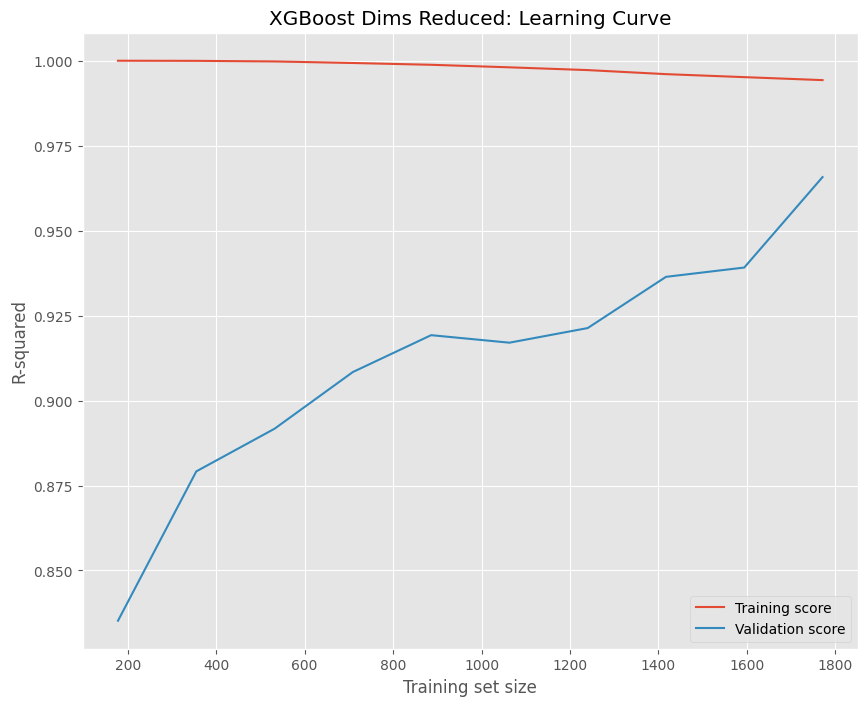

In [286]:
# Learning Curve - see how model improves with more data - also get SHAP as I train

def compute_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
   
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    # Compute mean SHAP values
    mean_shap_values = np.mean(shap_values, axis=0)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame({'feature': transformed_feature_names, 'mean_shap_value': mean_shap_values})

# Lists to store results
train_sizes = []
train_scores = []
validation_scores = []
shap_values_dfs = []

# Define range of training set sizes 
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    # Calc SHAP vals per subset
    shap_df = compute_shap_values(best_xgb_pipeline, X_train_sub, y_train_sub, X_val_sub)    
    shap_values_dfs.append(shap_df)
    
    # Store training set size
    train_sizes.append(X_train_sub.shape[0])

    # Evaluate model by set size
    train_predictions = best_xgb_pipeline.predict(X_train_sub)
    train_score = r2_score(y_train_sub, train_predictions)
    train_scores.append(train_score)

    # Evaluate on validation set
    val_predictions = best_xgb_pipeline.predict(X_val_sub)
    val_score = r2_score(y_val_sub, val_predictions)
    validation_scores.append(val_score)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_scores, label='Training score')
plt.plot(train_sizes, validation_scores, label='Validation score')
plt.ylabel('R-squared')
plt.xlabel('Training set size')
plt.title('XGBoost Dims Reduced: Learning Curve')
plt.legend()
plt.show()
    

[11:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-au

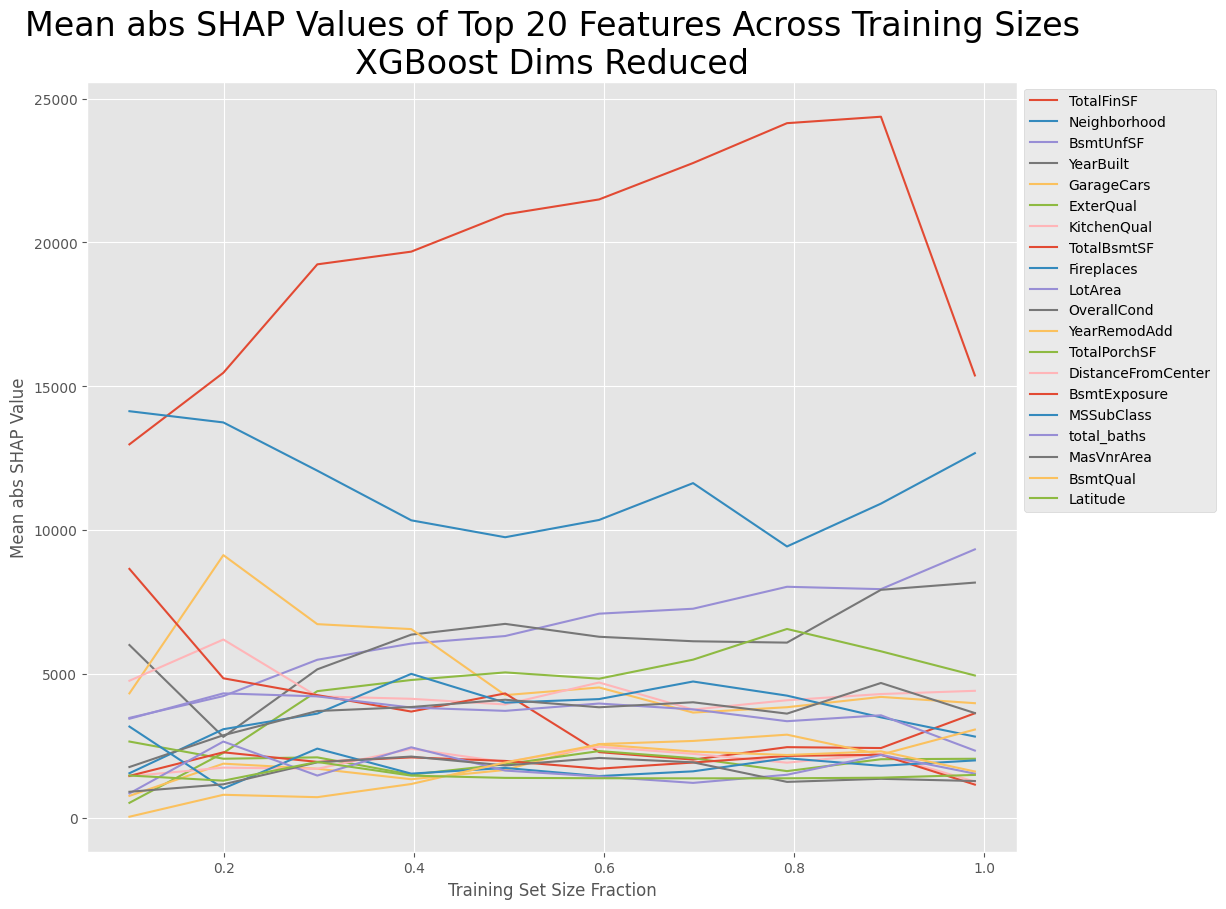

In [287]:
# Now plot the changes in SHAP values per training set size

# Function to calc abs SHAP values and pair with feature names
def compute_abs_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    abs_shap_values = np.abs(shap_values)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame(abs_shap_values, columns=transformed_feature_names)

# Lists to store results
train_sizes = []
shap_values_aggregated = pd.DataFrame()

# Compute mean abs SHAP vals per training set size model
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    abs_shap_df = compute_abs_shap_values(best_xgb_pipeline, X_train_sub, y_train_sub, X_val_sub)
    shap_values_aggregated[frac] = abs_shap_df.mean()

    train_sizes.append(X_train_sub.shape[0])

# Convert fractions to consistent format (e.g., string) for df column names
train_sizes_str = [str(size) for size in train_sizes]

# Get top 20 features
top_features = shap_values_aggregated.mean(axis=1).nlargest(20).index

# Remove prefix from feature names
top_features_cleaned = top_features.str.replace('^cat__|^remainder__|^target_enc__', '', regex=True)

# Initialize df 
top_features_shap_values = pd.DataFrame(index=top_features_cleaned)

# Populate df with mean abs SHAP values for top features across all training sizes
for size in shap_values_aggregated.columns:
    for feature, cleaned_feature in zip(top_features, top_features_cleaned):
        top_features_shap_values.at[cleaned_feature, size] = shap_values_aggregated.at[feature, size]

# Plot
plt.figure(figsize=(12, 10))
for feature in top_features_shap_values.index:
    plt.plot(shap_values_aggregated.columns, top_features_shap_values.loc[feature, :], label=feature)

plt.xlabel('Training Set Size Fraction')
plt.ylabel('Mean abs SHAP Value')
plt.title('Mean abs SHAP Values of Top 20 Features Across Training Sizes\nXGBoost Dims Reduced', fontsize=24)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

              Mean Abs SHAP Value  Std Dev SHAP Value          2.5%  \
TotalFinSF           21053.529297         1714.193848  17576.908301   
Neighborhood         11246.291016         1432.351685   8608.130347   
YearBuilt             7229.673828         1301.363647   4795.832458   
BsmtUnfSF             6489.534180          480.079071   5578.120178   
ExterQual             4685.700195         1439.986572   2125.373090   
KitchenQual           4367.213379          825.139526   2852.808911   
GarageCars            4115.243164          868.508789   2710.686328   
Fireplaces            4100.649414          472.307434   3275.294379   
OverallCond           3841.340332          331.080048   3242.592169   
LotArea               3495.764893          428.423248   2694.975720   

                     97.5%  
TotalFinSF    24303.544482  
Neighborhood  14122.450171  
YearBuilt      9782.196973  
BsmtUnfSF      7377.276794  
ExterQual      7582.529138  
KitchenQual    6181.596631  
GarageCars     

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


<Figure size 1200x700 with 0 Axes>

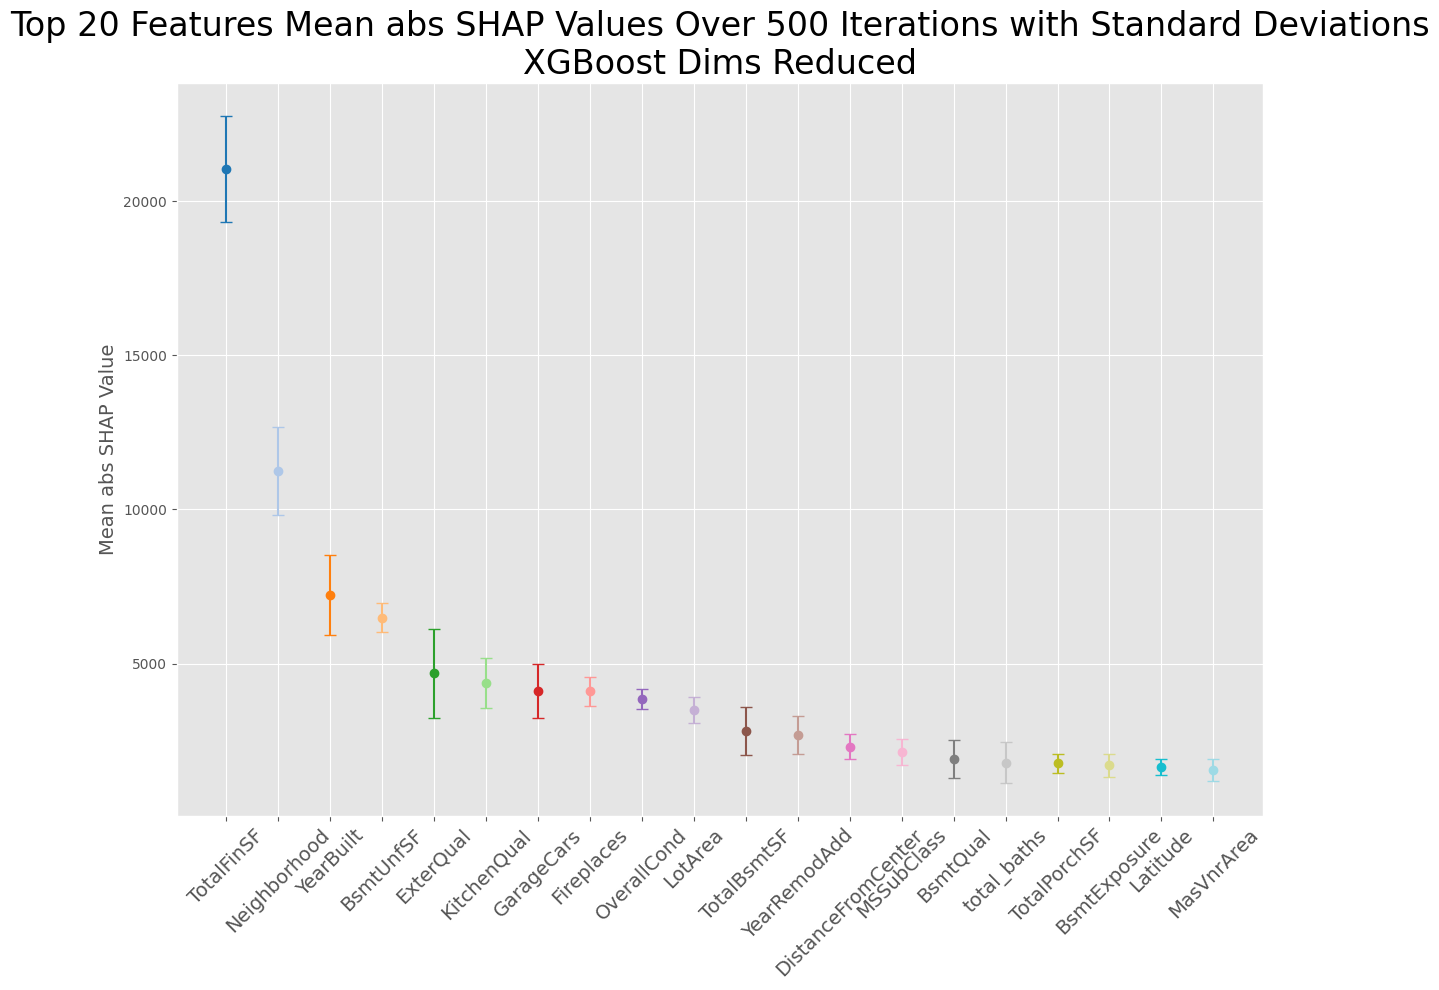

In [288]:
# Calc mean abs shap values per feature over 500 boostrapping iterations and see avgs and st devs for variability

from joblib import Parallel, delayed
from sklearn.utils import resample

# Use the pipeline that includes the XGBoost regressor and preprocessing
xgb_pipeline = best_xgb_pipeline

# Define a function to compute SHAP values on bootstrap samples
def compute_bootstrap_shap_values(X, y, pipeline, n):
    import shap
    from sklearn.utils import resample

    # Resample the data
    X_sample, y_sample = resample(X, y, replace=True)
    
    # Train the pipeline on the resampled data
    pipeline.fit(X_sample, y_sample)
    
    # Extract the trained model from the pipeline
    trained_model = pipeline.named_steps['regressor']
    
    # Get the preprocessed features from the pipeline
    X_sample_transformed = pipeline.named_steps['preprocessor'].transform(X_sample)

    print(f"Computing SHAP values for bootstrap sample ...")

    # Create SHAP explainer and calc SHAP values
    explainer = shap.TreeExplainer(trained_model)
    shap_values = explainer.shap_values(X_sample_transformed)

    # Calc the mean abs SHAP values
    mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
    
    # Retrieve feature names
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Return the mean SHAP values along with feature names
    return pd.Series(mean_abs_shap_values, index=feature_names)

# Number of bootstrapping iterations
n_iterations = 500
n_jobs = -1  # Use all available cores

# Perform the bootstrap calculations
bootstrap_results = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_bootstrap_shap_values)(X_train, y_train, xgb_pipeline, len(y_train)) for i in range(n_iterations)
)

# Convert the results to a DataFrame
bootstrap_shap_values = pd.DataFrame(bootstrap_results)

# Calc the mean and standard deviation of the SHAP values
mean_abs_shap_values = bootstrap_shap_values.mean(axis=0)
std_shap_values = bootstrap_shap_values.std(axis=0)

# Calc the confidence intervals
conf_intervals = bootstrap_shap_values.quantile([0.025, 0.975], axis=0).T
conf_intervals.columns = ['2.5%', '97.5%']

# Combine mean, std, and confidence intervals into one DataFrame
xgb_shap_stats = pd.DataFrame({
    'Mean Abs SHAP Value': mean_abs_shap_values, 
    'Std Dev SHAP Value': std_shap_values
}).join(conf_intervals)


# Sort the features by the abs mean SHAP value
xgb_shap_stats = xgb_shap_stats.reindex(mean_abs_shap_values.abs().sort_values(ascending=False).index)
xgb_shap_stats.index = xgb_shap_stats.index.str.replace('^cat__|^remainder__|^target_enc__', '', regex=True)

# Print the top 10 features for inspection
print(xgb_shap_stats.head(10))

# Now you can use mean_shap_values and conf_intervals as needed for further analysis or plotting
top_20_features = xgb_shap_stats['Mean Abs SHAP Value'].abs().sort_values(ascending=False).head(20).index

# Plot mean of top ten most impactful features with std dev
plt.figure(figsize=(12, 7))

top_20_features = xgb_shap_stats.head(20)

# Generate a list of colors
colors = plt.cm.tab20(np.linspace(0, 1, 20))

plt.figure(figsize=(12, 10))

# Plot each feature with a unique color
for i, (feature_name, row) in enumerate(top_20_features.iterrows()):
    plt.errorbar(i, row['Mean Abs SHAP Value'], yerr=row['Std Dev SHAP Value'], fmt='o', capsize=4, color=colors[i], label=feature_name)

plt.xticks(range(len(top_20_features)), top_20_features.index, rotation=45, fontsize=14)
plt.ylabel('Mean abs SHAP Value', fontsize=14)
plt.title('Top 20 Features Mean abs SHAP Values Over 500 Iterations with Standard Deviations\nXGBoost Dims Reduced', fontsize=24)

# Create a custom legend
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [289]:
#MARKINGSPOT
ames_dimreduced = pd.read_csv(r"C:\Users\willf\OneDrive\Documents\NYDSA\Machine Learning Project\AMES_GIT\ames_dimreduced.csv", keep_default_na=False)
ames_dimreduced = ames_dimreduced.drop(columns=['Unnamed: 0', 'PID', 'LogSalePrice'])

# Define dataset
X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

X.shape

(2556, 44)

In [290]:
def compute_bootstrap_feature_importance(X, y, pipeline):
    from sklearn.utils import resample

    # Resample data
    X_sample, y_sample = resample(X, y, replace=True)
    
    # Train the pipeline on the resampled data
    pipeline.fit(X_sample, y_sample)
    
    # Extract the trained model from the pipeline
    trained_model = pipeline.named_steps['regressor']
    
    # Extract feature names correctly considering the transformations
    feature_names = get_feature_names(pipeline.named_steps['preprocessor'], X.columns)
    
    # Get feature importances from the trained model
    feature_importances = trained_model.feature_importances_
    
    # Map importances to the correct feature names
    return pd.Series(feature_importances, index=feature_names)


(2556, 44)


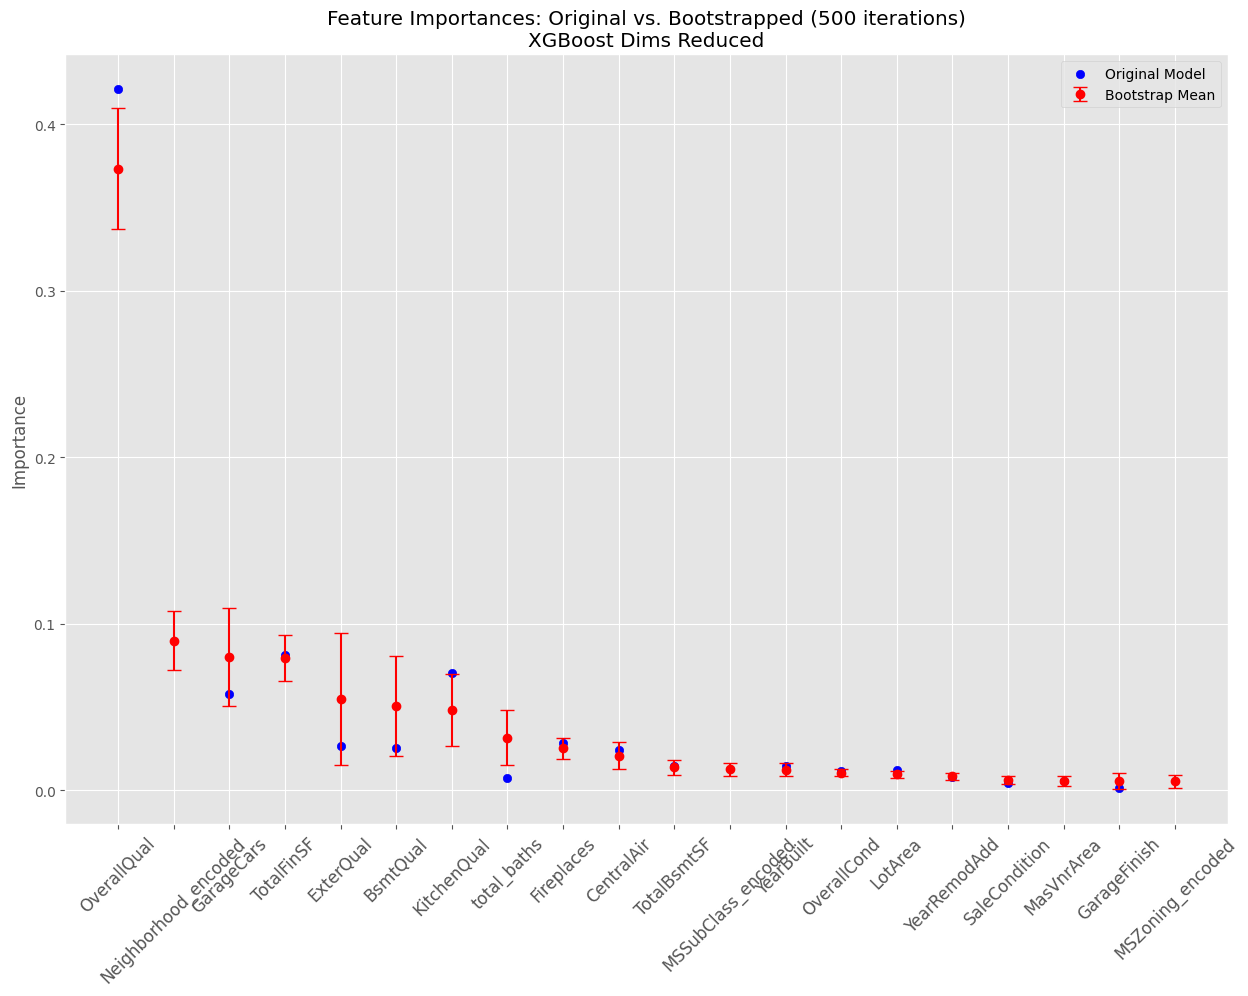

In [298]:
from joblib import Parallel, delayed


ames_dimreduced = pd.read_csv(r"C:\Users\willf\OneDrive\Documents\NYDSA\Machine Learning Project\AMES_GIT\ames_dimreduced.csv", keep_default_na=False)
ames_dimreduced = ames_dimreduced.drop(columns=['Unnamed: 0', 'PID', 'LogSalePrice'])

# Define dataset
X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

print(X.shape)

xgb_pipeline = best_xgb_pipeline

# Function to compute feature importances on bootstrap sample
def compute_bootstrap_feature_importance(X, y, pipeline):
    from sklearn.utils import resample

    # Resample data
    X_sample, y_sample = resample(X, y, replace=True)
    
    # Train the pipeline on the resampled data
    pipeline.fit(X_sample, y_sample)
    
    # Extract the trained model from the pipeline
    trained_model = pipeline.named_steps['regressor']
    
    # Extract feature importances
    feature_importances = trained_model.feature_importances_
    
    # Assuming the order and number of features in the model matches `all_features`
    feature_importance_series = pd.Series(feature_importances, index=all_features)
    
    return feature_importance_series


# Parallel computation of bootstrapped feature importances
n_iterations = 500  
n_jobs = -1  # Use all available cores for parallel processing

# Parallel computation of bootstrapped feature importances
bootstrap_feature_importances = Parallel(n_jobs=n_jobs)(
    delayed(compute_bootstrap_feature_importance)(X, y, best_xgb_pipeline) for _ in range(n_iterations)
)

# Convert to DataFrame
feature_importances_df = pd.DataFrame(bootstrap_feature_importances).T  # Transpose to have features as rows

# Calculate mean and std deviation of feature importances
mean_feature_importances = feature_importances_df.mean(axis=1)
std_feature_importances = feature_importances_df.std(axis=1)

# Create DataFrame with results
xgb_bootstrap_feature_importance_stats = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Std Dev Importance': std_feature_importances
}).sort_values(by='Mean Importance', ascending=False)

# Sort by mean importance
xgb_bootstrap_feature_importance_stats.sort_values(by='Mean Importance', ascending=False, inplace=True)

# Plot the top features based on mean importance
top_n = 20  
top_features = xgb_bootstrap_feature_importance_stats.head(top_n)

plt.figure(figsize=(15, 10))

# Iterate over bootstrapped features to plot them with error bars
for i, (feature_name, row) in enumerate(top_features.iterrows()):
    plt.errorbar(i, row['Mean Importance'], yerr=row['Std Dev Importance'], fmt='o', capsize=5, color='red', label='Bootstrap Mean' if i == 0 else "")

# Plot original model's importances as dots
# Ensure that we only plot for the features present in top_features
original_importances = xgb_original_feature_importance.set_index('Feature').reindex(top_features.index)['Importance']
plt.scatter(original_importances.index, original_importances, color='blue', label='Original Model')

plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Importance')
plt.title(f"Feature Importances: Original vs. Bootstrapped ({n_iterations} iterations)\nXGBoost Dims Reduced")
plt.legend()

plt.tight_layout

plt.show()


--------------------------------------------------------------Random Forest--------------------------------------------------

In [299]:
# Run Random Forest wtarget encoding and pipeline creation

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import category_encoders as ce

# Set pipeline for cross validation

# Define dataset
X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

# Define target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Define transformer for target encoding
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

# Create pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', rf_preprocessor),
                           ('regressor', RandomForestRegressor(criterion='squared_error', random_state=42))])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Fit 
rf_pipeline.fit(X_train, y_train)

# Get RF model params
random_forest_model = rf_pipeline.named_steps['regressor']
print("Random Forest hyperparameters:")
print(random_forest_model.get_params())

# Evaluate model
rf_predictions = rf_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, rf_predictions)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

# Perform CV
scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", scores)


Random Forest hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RMSE: 20633.480253432994
R-squared: 0.9097052576675856
Cross-validated R-squared scores: [0.89294795 0.89974756 0.93078259 0.90170197 0.91863084]


In [300]:
# Tune Hyperparams with grid search
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Create pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))])

# Instantiate grid search
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit Grid Search
rf_grid_search.fit(X,y)

print("Best Parameters", rf_grid_search.best_params_)

Best Parameters {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}


In [301]:
# Re-model with best params

rf_final_model = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators= 200,
        max_depth= 20,
        min_samples_split=2,
        random_state=42
    ))
])

# Fit 
rf_final_model.fit(X_train, y_train)

# Predict & evaluate
rf_predictions = rf_final_model.predict(X_test)
r2 = r2_score(y_test, rf_predictions)
print(f"R-squared error: {r2}")


R-squared error: 0.9119177048242351


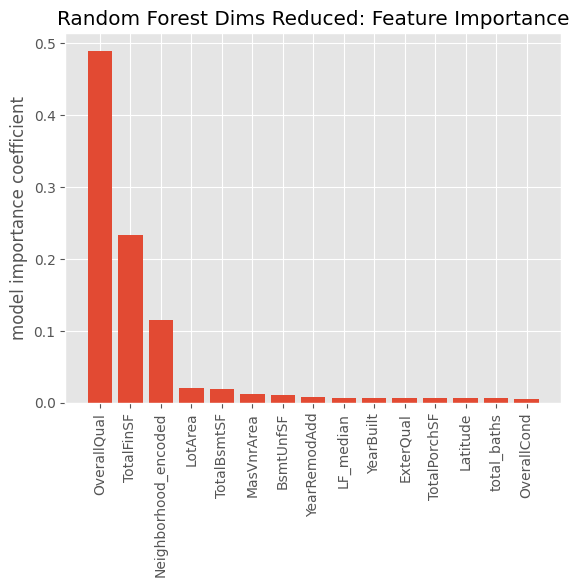

In [302]:
# Extract feature importance from best rf model
rf_feature_importances = rf_final_model.named_steps['regressor'].feature_importances_

# Get feature names 
target_encoded_feature = ['MSSubClass_encoded', 'MSZoning_encoded', 'Neighborhood_encoded', 'Condition1_encoded', 'Condition2_encoded',
'HouseStyle_encoded', 'RoofStyle_encoded', 'Exterior1st_encoded', 'Electrical_encoded', 'ClassPr_S_encoded']

# Get numeric feature names
numeric_features = X.select_dtypes(exclude=['object']).columns

# Combine feature names
all_features = np.concatenate([target_encoded_feature, numeric_features])

# Map feature importance to feature names
feature_importance_dict = dict(zip(all_features, rf_feature_importances))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

rf_feature_importance = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'], index=None)

# Plot 
import matplotlib.pyplot as plt

rf_importance_15 = rf_feature_importance.head(15)
plt.bar(rf_importance_15['Feature'], rf_importance_15['Importance'])
plt.xticks(rotation=90)
plt.ylabel('model importance coefficient')
plt.title("Random Forest Dims Reduced: Feature Importance")
plt.show()


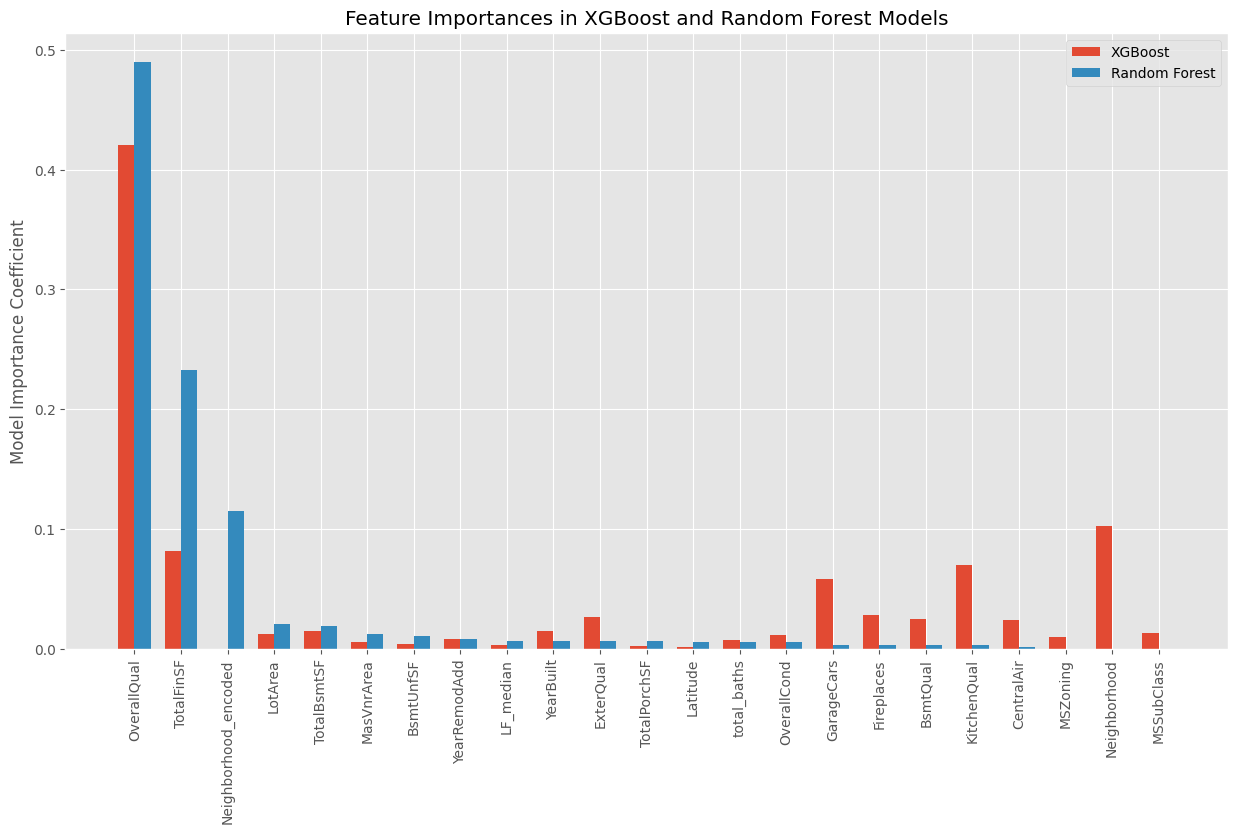

In [305]:
# Get top 15 features for both models
top_15_xgb = xgb_original_feature_importance.nlargest(15, 'Importance')
top_15_rf = rf_feature_importance.nlargest(15, 'Importance')

# Create a list of unique features present in top 15 of either model
unique_features = list(set(top_15_xgb['Feature']).union(set(top_15_rf['Feature'])))

# Prepare a combined DataFrame
combined = pd.DataFrame(index=unique_features)

# Add importances from both models to the combined DataFrame
combined = combined.join(xgb_original_feature_importance.set_index('Feature')).join(rf_feature_importance.set_index('Feature'), lsuffix='_xgb', rsuffix='_rf')

# Replace NaN values with 0 (for features not in top 15 in one of the models)
combined.fillna(0, inplace=True)

combined.sort_values(by='Importance_rf', ascending=False, inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
width = 0.35  # Width of the bars

# Creating bar positions
ind = np.arange(len(combined))

# Plotting XGBoost and Random Forest importances side by side
ax.bar(ind - width/2, combined['Importance_xgb'], width, label='XGBoost')
ax.bar(ind + width/2, combined['Importance_rf'], width, label='Random Forest')

# Labels and titles
ax.set_ylabel('Model Importance Coefficient')
ax.set_title('Feature Importances in XGBoost and Random Forest Models')
ax.set_xticks(ind)
ax.set_xticklabels(combined.index, rotation=90)
ax.legend()

plt.show()

In [303]:
# models_feature_importance = rf_feature_importance.merge(xgb_original_feature_importance, on='feature', how='left')
# models_feature_importance.rename(columns={'mean_abs_shap_x': 'rf_mean_abs_shap', 'mean_abs_shap_y': 'xgb_mean_abs_shap'}, inplace=True)

# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming models_feature_importance contains columns 'feature', 'rf_mean_abs_shap', 'xgb_mean_abs_shap'

# # Identify top 15 features for RF and XGB
# top15_rf_features = models_feature_importance.nlargest(15, 'rf_mean_abs_shap')['feature']
# top15_xgb_features = models_feature_importance.nlargest(15, 'xgb_mean_abs_shap')['feature']

# # Create a list of unique features from both lists
# unique_features = pd.unique(top15_rf_features.tolist() + top15_xgb_features.tolist())

# # Construct a new DataFrame that includes these unique features with their corresponding SHAP values
# # Ensure we include all unique features' values by merging against the original DataFrame
# top_features_combined = models_feature_importance[models_feature_importance['feature'].isin(unique_features)]

# top_features_combined = top_features_combined.sort_values(by='rf_mean_abs_shap', ascending=False)

# # Plotting
# plt.figure(figsize=(12, 8))

# # Width of a bar
# barWidth = 0.3

# # Set position of bar on X axis
# r1 = range(len(top_features_combined))
# r2 = [x + barWidth for x in r1]

# # Make the plot
# plt.bar(r1, top_features_combined['rf_mean_abs_shap'], color='blue', width=barWidth, edgecolor='grey', label='RF Mean Abs SHAP')
# plt.bar(r2, top_features_combined['xgb_mean_abs_shap'], color='red', width=barWidth, edgecolor='grey', label='XGB Mean Abs SHAP')

# # Add xticks on the middle of the group bars
# plt.xlabel('Feature', fontweight='bold')
# plt.xticks([r + barWidth/2 for r in range(len(top_features_combined))], top_features_combined['feature'], rotation=90)

# # Create legend & Show graphic
# plt.legend()
# plt.title('Top 15 Features by Mean Abs SHAP Values for RF vs. XGB\n Reduced Dims Models', fontsize=18)
# plt.show()


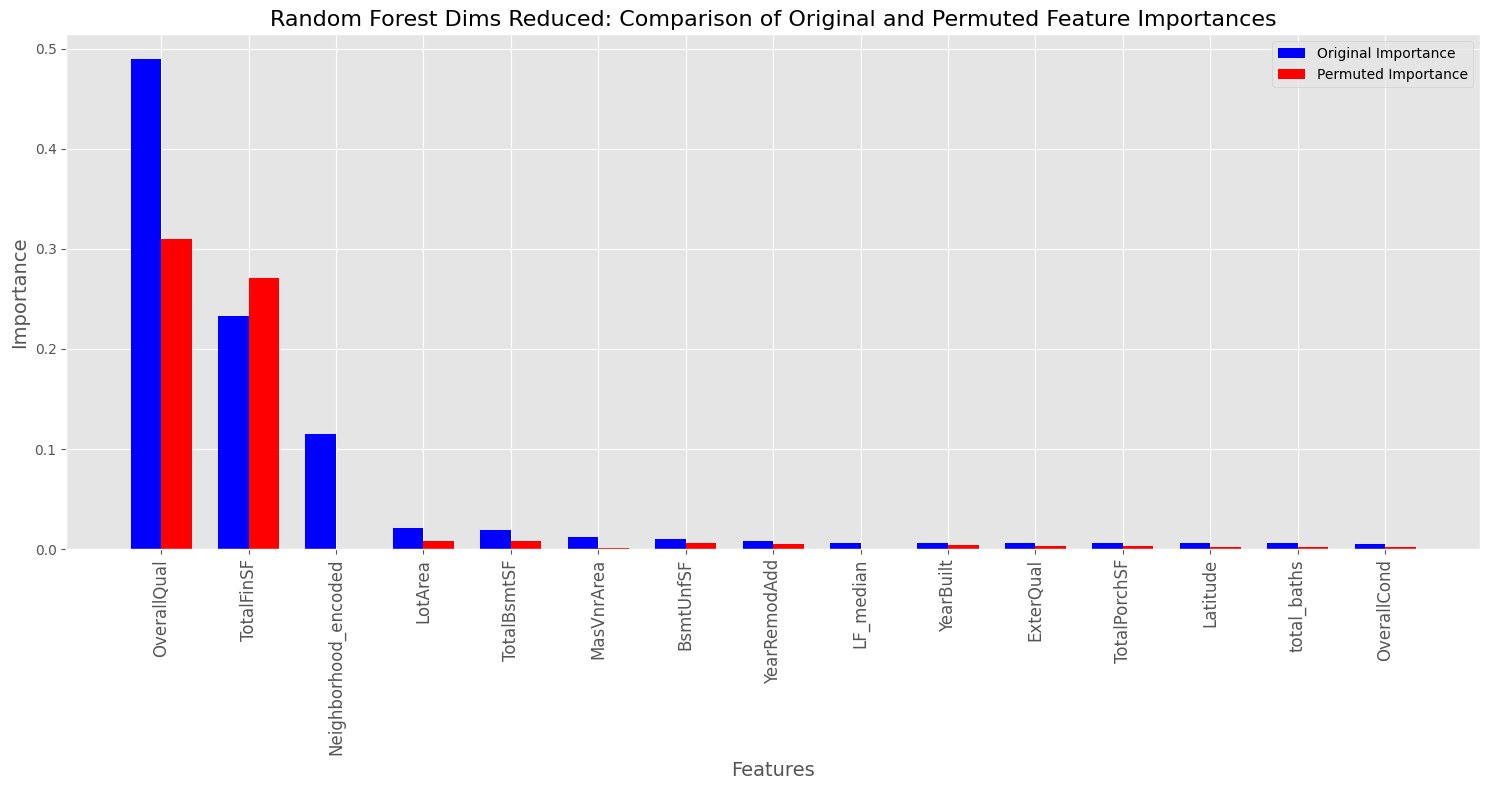

In [306]:
# Compare model feature importance to permuted feature importance

from sklearn.inspection import permutation_importance

# Func to get permuted importances
def permuted_feature_importance(pipeline, X_test, y_test):
    baseline_r2 = r2_score(y_test, pipeline.predict(X_test))
    importances = {}

    for feature in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

        permuted_r2 = r2_score(y_test, pipeline.predict(X_test_permuted))
        importances[feature] = baseline_r2 - permuted_r2

    return importances

# Calc permuted importance
rf_permuted_importances = permuted_feature_importance(rf_final_model, X_test, y_test)

# Convert to DF & sort
rf_permuted_importances_df = pd.DataFrame.from_dict(rf_permuted_importances, orient='index', columns=['Importance'])
rf_permuted_importances_df.sort_values(by='Importance', ascending=False, inplace=True)


# Select top 15 features from model importances for comparison
top_features = rf_feature_importance.head(15)['Feature']

# Initialize DF to store comparison
comparison_importances = pd.DataFrame(index=top_features)

# Get model importances for top features
comparison_importances['Original Importance'] = rf_feature_importance.set_index('Feature').reindex(top_features)['Importance']

# Get  permuted importances for same features
comparison_importances['Permuted Importance'] = rf_permuted_importances_df.reindex(top_features)['Importance']

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.35
index = np.arange(len(top_features))

ax.bar(index, comparison_importances['Original Importance'], bar_width, label='Original Importance', color='b')
ax.bar(index + bar_width, comparison_importances['Permuted Importance'], bar_width, label='Permuted Importance', color='r')

ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
ax.set_title('Random Forest Dims Reduced: Comparison of Original and Permuted Feature Importances', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_importances.index, rotation=90, fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
X_train_preprocessed.shape

(1789, 44)

 99%|===================| 1777/1789 [01:42<00:00]        

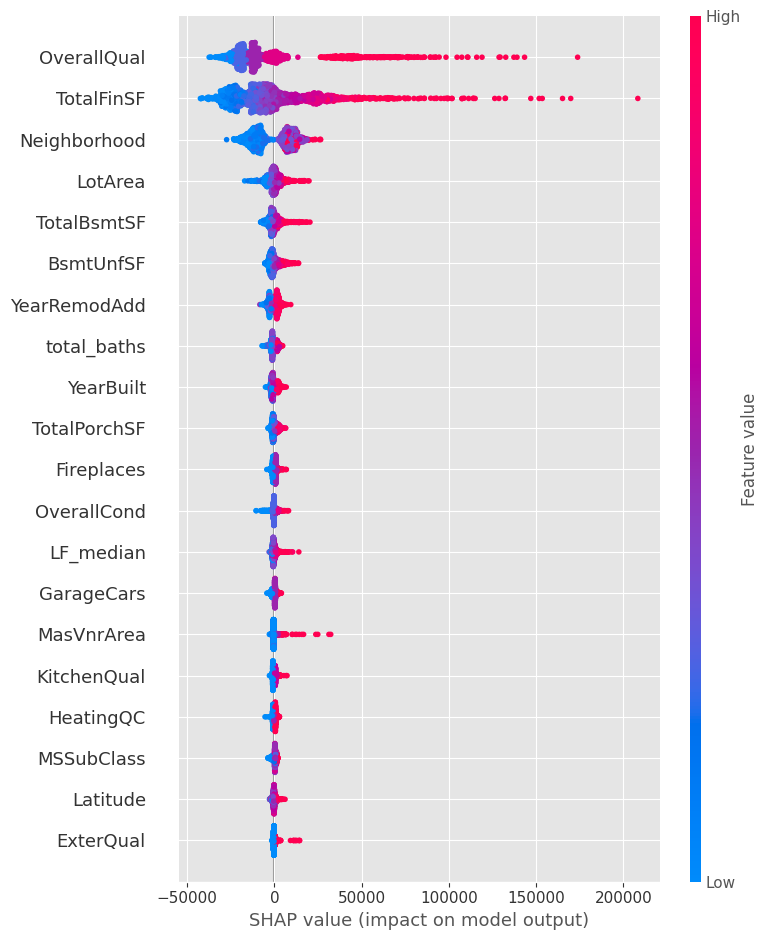

In [307]:
# Get RF SHAP values

rf_model = rf_final_model.named_steps['regressor']


# Create SHAP explainer
explainer = shap.Explainer(rf_model, X_train_preprocessed)

shap_values = explainer(X_train_preprocessed)

shap.summary_plot(shap_values, X_train_preprocessed, feature_names=correct_feature_names)


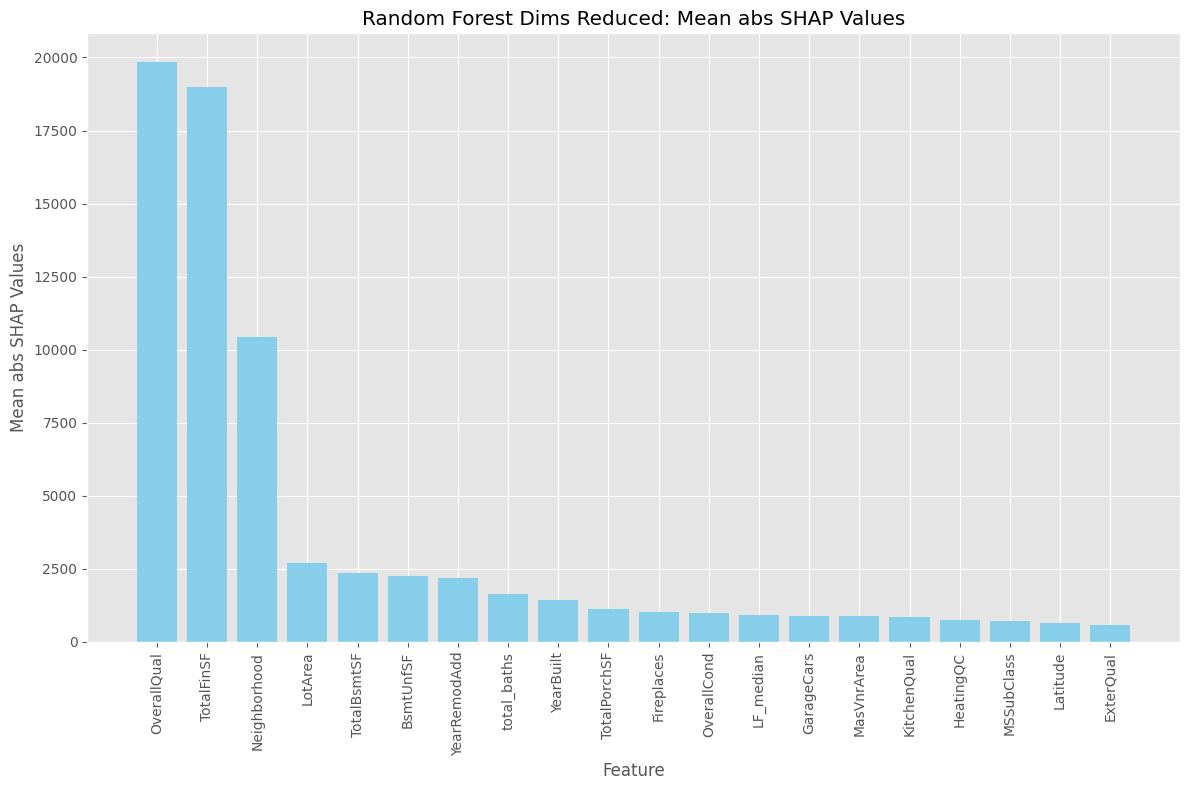

In [308]:
# Plot mean abs shap values 
rf_mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

feature_names = correct_feature_names

rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': rf_mean_abs_shap
})

top_features = feature_importance.sort_values(by='mean_abs_shap', ascending=False).head(20)

plt.style.use("ggplot")
# Plot
plt.figure(figsize=(12,8))
plt.bar(top_features['feature'], top_features['mean_abs_shap'], color='skyblue')
plt.ylabel('Mean abs SHAP Values')
plt.xlabel('Feature')
plt.title('Random Forest Dims Reduced: Mean abs SHAP Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [309]:
# explainer = shap.TreeExplainer(rf_model)
interaction_values = explainer.shap_interaction_values(X_test_preprocessed)
interaction_values

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [310]:
# # Create and plot top 3 interaction features for each of  top 20 XGB model features (by mean abs SHAP val)

# # Initialize TreeExplainer
# tree_explainer = shap.TreeExplainer(rf_model)

# interaction_values = tree_explainer.shap_interaction_values(X_train_preprocessed)

# # Calc mean interaction values across all samples
# mean_interaction_values = np.abs(interaction_values).mean(axis=0)

# top_20_feature_names = top_features['feature'].head(20)

# top_20_feature_names_list = top_20_feature_names.tolist()


# # Create a dictionary to hold  top 3 interactions for each feature
# top_interactions = {}

# # Iterate over each of the top 20 features
# for feature in top_20_feature_names_list:
#     # Check if the feature is in the correct_feature_names list
#     if feature in correct_feature_names:
#         # Get the index of the feature
#         feature_idx = correct_feature_names.index(feature)

#         # Get the interaction values of this feature with all other features
#         feature_interactions = mean_interaction_values[feature_idx, :]
        
#         # Get the top 3 interactions excluding the self-interaction
#         top_3_idx = np.argsort(feature_interactions)[-4:-1]  # Exclude last one: the feature itself
#         top_3_features = [correct_feature_names[i] for i in top_3_idx]
#         top_3_values = feature_interactions[top_3_idx]

#         # Store in dictionary
#         top_interactions[feature] = (top_3_features, top_3_values)
#     else:
#         print(f"Feature '{feature}' not found in correct_feature_names")

# # Create func for plotting
# def plot_feature_interactions(interactions_dict, features, ax):
#     for i, feature in enumerate(features):
#         # Ensure feature is in the dictionary
#         if feature not in interactions_dict:
#             print(f"Feature '{feature}' not in interactions_dict")
#             continue

#         interacting_features, values = interactions_dict[feature]

#         # Sort the values in descending order and get sorted indices
#         sorted_idx = np.argsort(values)[::-1].astype(int)  # Convert to integer
#         values = values[sorted_idx]

#         # Use list comprehension for indexing
#         interacting_features = [interacting_features[i] for i in sorted_idx]

#         # ... rest of the code ...


#         # Position of bars for this feature
#         bar_positions = np.array(range(i*4, i*4 + 3))
        
#         # Plot  bars
#         ax.bar(bar_positions, values)

#         # Annotate bars with feature names
#         for pos, val, interact_feature in zip(bar_positions, values, interacting_features):
#             ax.text(pos, val + 0.02 * max(values), interact_feature, ha='center', va='bottom', rotation=90, fontsize=9)

#     # Set  x-ticks to be in  middle of each group of bars
#     ax.set_xticks([i*4 + 1 for i in range(len(features))])
#     ax.set_xticklabels(features, rotation=45, ha='right', fontsize=11)
#     ax.set_ylabel('Mean abs SHAP Interaction Value', fontsize=12)

# # Split  top 20 features into two groups of 10
# first_10_features = list(top_20_feature_names)[:10]
# second_10_features = list(top_20_feature_names)[10:]

# # Create subplots 
# fig, axs = plt.subplots(2, 1, figsize=(24, 24), gridspec_kw={'hspace': 0.6})  # Adjust horizontal spacing

# # Plot interactions for  first 10 features
# plot_feature_interactions(top_interactions, first_10_features, axs[0])
# axs[0].set_title('RF Dims Reduced: Top 3 Interacting Features for  First 10 of  Top 20 Features', fontsize=14)

# # Plot interactions for  second 10 features
# plot_feature_interactions(top_interactions, second_10_features, axs[1])
# axs[1].set_title('RF Dims Reduced: Top 3 Interacting Features for  Second 10 of  Top 20 Features', fontsize=14)

# # Show  plot with adjusted layout
# # plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
# plt.show()


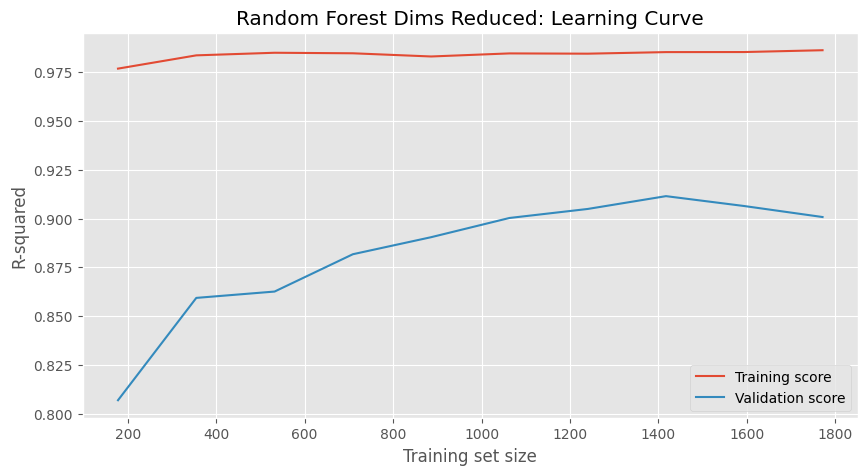

In [311]:
# Learning Curve - see how model improves with more data - also get SHAP as I train

from sklearn.metrics import mean_squared_error, r2_score

def compute_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
   
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    # Compute mean SHAP values
    mean_shap_values = np.mean(shap_values, axis=0)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame({'feature': transformed_feature_names, 'mean_shap_value': mean_shap_values})

# Lists to store results
train_sizes = []
train_scores = []
validation_scores = []
shap_values_dfs = []

# Define range of training set sizes 
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    # Calc SHAP vals per subset
    shap_df = compute_shap_values(rf_final_model, X_train_sub, y_train_sub, X_val_sub)    
    shap_values_dfs.append(shap_df)
    
    # Store training set size
    train_sizes.append(X_train_sub.shape[0])

    # Evaluate model by set size
    train_predictions = rf_final_model.predict(X_train_sub)
    train_score = r2_score(y_train_sub, train_predictions)
    train_scores.append(train_score)

    # Evaluate on validation set
    val_predictions = rf_final_model.predict(X_val_sub)
    val_score = r2_score(y_val_sub, val_predictions)
    validation_scores.append(val_score)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_scores, label='Training score')
plt.plot(train_sizes, validation_scores, label='Validation score')
plt.ylabel('R-squared')
plt.xlabel('Training set size')
plt.title('Random Forest Dims Reduced: Learning Curve')
plt.legend()
plt.show()
    

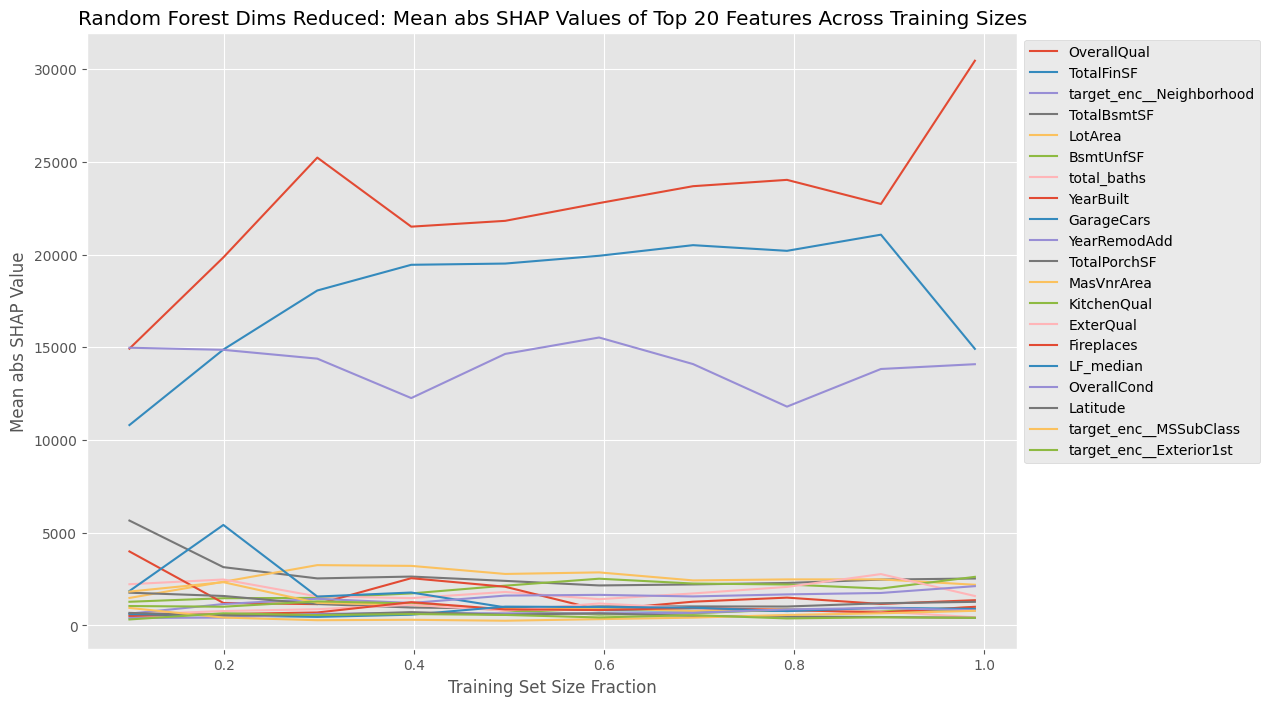

In [312]:
# Now plot the changes in SHAP values per training set size

# Function to calc abs SHAP values and pair with feature names
def compute_abs_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    abs_shap_values = np.abs(shap_values)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame(abs_shap_values, columns=transformed_feature_names)

# Lists to store results
train_sizes = []
shap_values_aggregated = pd.DataFrame()

# Compute mean abs SHAP vals per training set size model
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    abs_shap_df = compute_abs_shap_values(rf_final_model, X_train_sub, y_train_sub, X_val_sub)
    shap_values_aggregated[frac] = abs_shap_df.mean()

    train_sizes.append(X_train_sub.shape[0])

# Convert fractions to consistent format (e.g., string) for df column names
train_sizes_str = [str(size) for size in train_sizes]

# Get top 20 features
top_features = shap_values_aggregated.mean(axis=1).nlargest(20).index

# Remove prefix from feature names
top_features_cleaned = top_features.str.replace('^cat__|^remainder__', '', regex=True)

# Initialize df 
top_features_shap_values = pd.DataFrame(index=top_features_cleaned)

# Populate df with mean abs SHAP values for top features across all training sizes
for size in shap_values_aggregated.columns:
    for feature, cleaned_feature in zip(top_features, top_features_cleaned):
        top_features_shap_values.at[cleaned_feature, size] = shap_values_aggregated.at[feature, size]

# Plot
plt.figure(figsize=(12, 8))
for feature in top_features_shap_values.index:
    plt.plot(shap_values_aggregated.columns, top_features_shap_values.loc[feature, :], label=feature)

plt.xlabel('Training Set Size Fraction')
plt.ylabel('Mean abs SHAP Value')
plt.title('Random Forest Dims Reduced: Mean abs SHAP Values of Top 20 Features Across Training Sizes')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



In [313]:
# Calc mean abs shap values per feature over 500 boostrapping iterations and see avgs and st devs for variability
# Note this takes a very long time to run!!!

from sklearn.utils import resample

# Define pipeline
rf_pipeline = rf_final_model

# Define func for boostrapping and getting SHAP vals
def compute_bootstrap_shap_values(X, y, pipeline, n):
    import shap
    from sklearn.utils import resample

    # Resample
    X_sample, y_sample = resample(X, y, replace=True)
    
    # Train 
    pipeline.fit(X_sample, y_sample)
    
    # Extract the trained model
    trained_model = pipeline.named_steps['regressor']
    
    # Get preprocessed features 
    X_sample_transformed = pipeline.named_steps['preprocessor'].transform(X_sample)

    # Create SHAP explainer and calc SHAP values
    explainer = shap.TreeExplainer(trained_model)
    shap_values = explainer.shap_values(X_sample_transformed)

    # Calc mean abs SHAP values
    mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
    
    # Get feature names
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Return mean SHAP vals & feature names
    return pd.Series(mean_abs_shap_values, index=feature_names)

# Number of bootstrapping iterations
n_iterations = 500
n_jobs = -1  

# Perform bootstrap calcs
bootstrap_results = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_bootstrap_shap_values)(X_train, y_train, rf_final_model, len(y_train)) for i in range(n_iterations)
)

# Convert results to DF
bootstrap_shap_values = pd.DataFrame(bootstrap_results)

# Calc the mean and st dev of SHAP vals
mean_abs_shap_values = bootstrap_shap_values.mean(axis=0)
std_shap_values = bootstrap_shap_values.std(axis=0)

# Calc confidence intervals
conf_intervals = bootstrap_shap_values.quantile([0.025, 0.975], axis=0).T
conf_intervals.columns = ['2.5%', '97.5%']

# Combine mean, std, and confidence intervals into one DF
rf_shap_stats = pd.DataFrame({
    'Mean Abs SHAP Value': mean_abs_shap_values, 
    'Std Dev SHAP Value': std_shap_values
}).join(conf_intervals)

# Sort features by mean abs SHAP value
rf_shap_stats = rf_shap_stats.reindex(mean_abs_shap_values.abs().sort_values(ascending=False).index)
rf_shap_stats.index = rf_shap_stats.index.str.replace('remainder__', '')

# Print top 10 features to check
print(rf_shap_stats.head(10))

top_20_features = rf_shap_stats['Mean Abs SHAP Value'].abs().sort_values(ascending=False).head(20).index

# Plot 
plt.figure(figsize=(12, 7))

top_20_features = rf_shap_stats.head(20)

colors = plt.cm.tab20(np.linspace(0, 1, 20))

plt.figure(figsize=(12, 7))

# Plot each feature with unique color
for i, (feature_name, row) in enumerate(top_20_features.iterrows()):
    plt.errorbar(i, row['Mean Abs SHAP Value'], yerr=row['Std Dev SHAP Value'], fmt='o', capsize=4, color=colors[i], label=feature_name)

plt.xticks(range(len(top_20_features)), top_20_features.index, rotation=90)
plt.ylabel('Mean abs SHAP Value')
plt.title('Random Forest Dims Reduced: Top 20 Features Mean abs SHAP Values Over 500 Iterations with Standard Deviations')

# Create a custom legend
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


[19:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[19:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


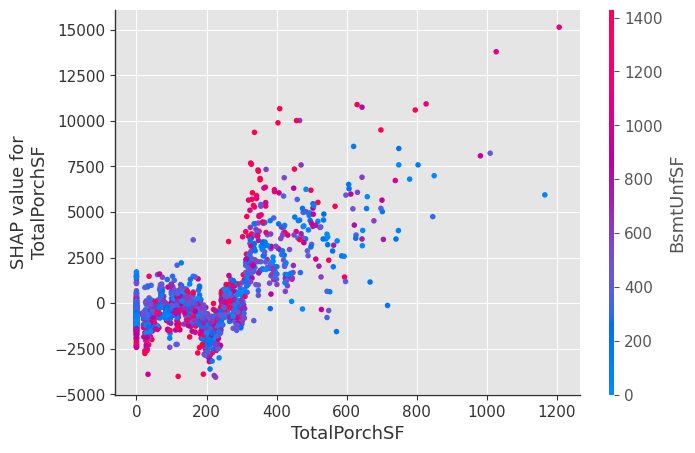

In [ ]:
# Plot interactive pairs of features as dependence plot
import matplotlib.pyplot as plt

# Define feature
feature_name = 'TotalPorchSF'

# Create SHAP explainer 
explainer = shap.Explainer(xgb_model, X_train_preprocessed)

# Calc SHAP vals
shap_values = explainer.shap_values(X_train_preprocessed)

# Generate dependence plot for feature (and interaction feature)
shap.dependence_plot(feature_name, shap_values, X_train_preprocessed, feature_names=correct_feature_names, interaction_index= 'BsmtUnfSF')
